** Notebook to reproduce the results in Ouchi et al. (2021)**

This notebook describes the codes that are needed to reproduce the results in Ouchi, Maeda, J.P.Anderson, Sawada (2021). 

# Preparation for the analysis

## Import libraries
First, let us import the libraries that are necessary. 

In [1]:
import math
import numpy as np
from numpy import random
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy.stats import powerlaw

random.seed(0)

lsol  = 3.8418*10**(33)  # Solar luminosity
ly  = 9.460528*pow(10,17) # light year (cm)
pc  = 3.261633*ly # parsec (cm)

## Define functions
Next, let us define the functions that are later used. Note that these are not all the functions used in this notebook. Some functions are defined later. 

In [2]:
# Functions that connect 56Ni mass to the observables in SN (e.g. Lp, tp).
    
def tp_for_M_Ni_using_fit_to_Meza(x, a_coef, b_coef):
    '''
    Predict time to peak from a given Ni mass using the paramters derived from linear fit.
    
    Argument: 
    x: Ni mass in unit of Msun.
    a_coef, b_coef: optimiazed parameters derived from linear regression.
    
    Out:
    tau: predicted time to peak in unit of day.
    '''
    # Maybe, it might have been better to set argument x as logx.
    tp = a_coef*np.log10(x) + b_coef 


    return tp
 
def Lpeak_for_tp_MNi(tp, MNi):
    '''
    Calculate peak luminosity using Arnett-rule.
    
    Argument:
    tp: time to peak in unit of day.
    MNi: Ni mass in unit of Msun.
    
    Out:
    Lpeak: peak luminosity (erg/s).
    '''

    Lpref = 6.45*np.exp(-tp/8.8) + 1.45*np.exp(-tp/111.3)
    Lpeak = Lpref*MNi*10**(43)
    return Lpeak 

def Lpeak_for_MNi_direct(MNi, a_coef, b_coef):
    '''
    Combine above two and derive Lp just from Ni mass.
    
    Argument:
    tp: time to peak in unit of day.
    MNi: Ni mass in unit of Msun.
    
    Out:
    Lpeak: peak luminosity.
    '''
    tp = tp_for_M_Ni_using_fit_to_Meza(MNi, a_coef, b_coef) # a_coef*np.log10(MNi) + b_coef
    
    Lpref = 6.45*np.exp(-tp/8.8) + 1.45*np.exp(-tp/111.3)
    Lpeak = Lpref*MNi*10**(43)
    return Lpeak
   
    
def dlog10Lpeak_dtp(x,a,b):
    '''
    Return derivativ of Lp to tp. 
    *Note
    dLpeak/dtp (x: fixed) = 10**(43+x)*(6.45*np.exp(-tp/8.8)*(-1/8.8) + 1.45*np.exp(-tp/111.3)*(-1/111.3)) 
    dlog10Lpeak/dtp = 1/(loge10*Lpeak)*dLpeak/dtp 
    
    Argument:
    x: log MNi(Msun)
    a, b: Coefficients for tp = a*x + b
    
    Out:
    dLpeak/dx: 
    '''
    tp =  tp_for_M_Ni_using_fit_to_Meza(10**x, a_coef, b_coef) # a_coef*np.log10(MNi) + b_coef
    # a*x+b
    
    dLpeak_dtp =  10**(43+x)*(6.45*np.exp(-tp/8.8)*(-1/8.8) + 1.45*np.exp(-tp/111.3)*(-1/111.3))

    Lpk = 10**(43+x)*(6.45*np.exp(-tp/8.8) + 1.45*np.exp(-tp/111.3))
    dlog10Lpeak_dtp = dLpeak_dtp/np.log(10)/Lpk
    
    return dlog10Lpeak_dtp

In [3]:
# Test 
# Check consistency

ni_test = 0.01
a_coef_test = 10
b_coef_test = 30

tp_test = tp_for_M_Ni_using_fit_to_Meza(ni_test, a_coef_test, b_coef_test)
assert Lpeak_for_MNi_direct(ni_test, a_coef_test, b_coef_test)==Lpeak_for_tp_MNi(tp_test, ni_test)

#print(Lpeak_for_MNi_direct(ni_test, a_coef_test, b_coef_test))
#print(Lpeak_for_tp_MNi(tp_test, ni_test))

Fit to 56Ni mass distribution of LS-SNe II.

In [4]:
a0 = 14.60436497

# I think it had been better to take "a0" as a argument.

def F(x):
    '''
    retunr fitted function to Ni mass distribution of LS-SNe II.
    
    Argutment
    x: Ni mass (Msun)
    
    Output
    Cumulative distribution function of Ni of LS-SNe II. 
    '''
    
    return np.tanh(a0*x)

def F_reverse(y):
    '''
    '''
    return np.arctanh(y)/a0


Below, we conduct a least square fit to data (xi, yi). We try the following two approaches.

1. From scratch
2. Using scipy curve_fit (for checking consistency).


In [5]:
def least_square_fit(X, Y):
    '''
    Just a standard least square fit.
    
    Argument
    X: array of x
    Y: array of Y
    
    Output
    a, b for ax+b that minimize mean square error.

    '''
    
    # Lest square fit
    s_xy = np.dot(X-np.mean(X), Y-np.mean(Y))/len(X)
    s_xx = np.dot(X-np.mean(X), X-np.mean(X))/len(X)

    a = s_xy/s_xx
    b = np.mean(Y)-a*np.mean(X)
    
    # Find error
    pred = a*X + b
    eps = Y - pred
  #  sigma = np.sqrt(np.var(eps))
    sigma = np.sqrt(np.dot(eps-np.mean(eps),eps-np.mean(eps))/(len(eps)-2))
    sigma = np.sqrt(np.dot(eps,eps)/(len(eps)-2))
    a_err = sigma/np.sqrt(np.dot(X-np.mean(X),X-np.mean(X)))
    b_err = sigma*np.sqrt(np.dot(X,X)/len(X)/np.dot(X-np.mean(X),X-np.mean(X)))
   # print(np.mean(eps))
    return a, b, a_err, b_err, sigma
    

In [6]:
# Test "from scratch"

X_test = np.array([1,2,5])
Y_test = np.array([23, -12, 33])

least_square_fit(X_test, Y_test)

(5.384615384615384,
 0.3076923076923084,
 9.992600812897368,
 31.599378317605733,
 29.417420270727604)

In [7]:
# Test "scipy"
from scipy.optimize import curve_fit

def func_test(x, a, b):
    return a*x + b

popt, pcov = curve_fit(func_test, X_test, Y_test)
perr = np.sqrt(np.diag(pcov))

popt, perr

(array([5.38461538, 0.30769231]), array([ 9.99259686, 31.59935943]))

The two results are consistent. Our implementation of "least_square_fit" is okay.

In [8]:
def D_from_distance_modulous(mu):
    '''
    convert distance modulous into Mpc.
    
    Argument: 
    mu: Distance modulous.
    d_Mpc: Corresponding distance in Mpc.
    '''
    d_pc = pow(10, (mu+5.0)/5.0)
    d_Mpc = d_pc/10**6
    return d_Mpc


def D_lim(lgL, V_lim):
    '''
    Calculate a limiting distance for a given luminosity.
    
    Argument: 
    lgL: 
    Vlim: Limiting magnitude in V band 
    
    Return:
    D_lim: Corresponding limiting diatance,
    '''

    A_t = 0.0
    BC = 0.0
    DMpc_lim = pow(10,(2.5*lgL+V_lim-A_t+BC+8.14)/5.0)/pc/pow(10,6)
    
    return DMpc_lim




# Load the data.
Below, we are going to load the data used in the paper.

## LS-SNe II and LS-SESNe.
First, let us load LS-SNe II, LS-SESNe.

In [42]:
data_II = pd.read_csv("./Data_Anderson_add_new_references/LS_SNeII.csv")
data_SESNe = pd.read_csv("./Data_Anderson_add_new_references/LS_SENeII.csv")
data_USSNe = pd.read_csv("./Data_Anderson_add_new_references/USSNe.csv")

In [43]:
# Since we only need average Ni mass, let us omit other data.
data_II_new = data_II.dropna(subset=['SN']) 
data_SESNe_new = data_SESNe.dropna(subset=['SN']) 
data_SESNe_new_excluding_IcBL = data_SESNe_new[data_SESNe_new['Type']!='Ic-BL']
data_SESNe_new_IcBL = data_SESNe_new[data_SESNe_new['Type'] =='Ic-BL']

In [44]:
# Extract numpy array of average 56Ni mass and distance.

ni_avg_II = data_II_new['Average/single values'].values.astype(np.float64)
distance_II = data_II_new['Distance (Mpc)'].values.astype(np.float64)

ni_avg_SESNe = data_SESNe_new['Average/single values'].values.astype(np.float64)
distance_SESNe = data_SESNe_new['Distance (Mpc)'].values.astype(np.float64)

ni_avg_SESNe_excluding_IcBL = data_SESNe_new_excluding_IcBL['Average/single values'].values.astype(np.float64)
distance_SESNe_excluding_IcBL = data_SESNe_new_excluding_IcBL['Distance (Mpc)'].values.astype(np.float64)

ni_avg_SESNe_IcBL = data_SESNe_new_IcBL['Average/single values'].values.astype(np.float64)
distance_SESNe_IcBL = data_SESNe_new_IcBL['Distance (Mpc)'].values.astype(np.float64)

ni_avg_USSNe = data_USSNe['Average/single values'].values.astype(np.float64)
distance_USSNe = data_USSNe['Distance (Mpc)'].values.astype(np.float64)

In [45]:
# Check the number of data
print("The size of LS-SNe II is:", len(data_II_new))
print("The size of LS-SESNe is:", len(data_SESNe_new))
print("The size of LS-SENe, excluding Ic-BL is:", len(data_SESNe_new_excluding_IcBL))
print("")

The size of LS-SNe II is: 115
The size of LS-SESNe is: 187
The size of LS-SENe, excluding Ic-BL is: 131



## Meza-SESNe
Next, we load Meza-SESNe.

In [46]:
#Load data of SESNe sample of Meza20.

# total data
data_meza = pd.read_csv('./Data_SESNe/Data_Meza_Anderson_2020.txt', comment='#', delim_whitespace=True)
lgL_meza = np.log10(data_meza['Lpeak'].values) + 41
distance_meza = data_meza['Host_dL'].values
ni_meza_arnett = data_meza['Ni_arnett'].values
ni_meza_kk = data_meza['K&K'].values
ni_meza_tail = data_meza['Tail'].values
ni_meza_tail_omit_none = ni_meza_tail[ni_meza_tail!='None'] # Omit none
tp_meza = data_meza['tpeak'].values

# excluding_IcBL
data_meza_excluding_IcBL = data_meza[(data_meza['Type'] != 'Ic-GRB') & (data_meza['Type'] != 'Ic-BL')]
ni_meza_arnett_excluding_IcBL = data_meza_excluding_IcBL["Ni_arnett"].values
ni_meza_kk_excluding_IcBL = data_meza_excluding_IcBL["K&K"].values
tp_meza_excluding_IcBL = data_meza_excluding_IcBL['tpeak'].values
distance_meza_excluding_IcBL = data_meza_excluding_IcBL['Host_dL'].values
lgL_meza_excluding_IcBL = np.log10(data_meza_excluding_IcBL['Lpeak'].values) + 41

# include IcBL
data_meza_IcBL = data_meza[(data_meza['Type'] == 'Ic-GRB') | (data_meza['Type'] == 'Ic-BL')]
ni_meza_arnett_IcBL = data_meza_IcBL["Ni_arnett"].values
ni_meza_kk_IcBL = data_meza_IcBL["K&K"].values
ni_meza_tail_IcBL = data_meza_IcBL["Tail"].values
tp_meza_IcBL = data_meza_IcBL['tpeak'].values
distance_meza_IcBL = data_meza_IcBL['Host_dL'].values
lgL_meza_IcBL = np.log10(data_meza_IcBL['Lpeak'].values) + 41


assert len(ni_meza_arnett_excluding_IcBL)+len(ni_meza_arnett_IcBL) == len(ni_meza_arnett)

print("The number of Meza sample is:", len(ni_meza_arnett))
print("The size of Meza-SESNe excluding Ic-BL is:", len(ni_meza_arnett_excluding_IcBL))

The number of Meza sample is: 37
The size of Meza-SESNe excluding Ic-BL is: 33


In [47]:
# Tail
# Note that there are some NANS in tail values. Lert us omit those.

data_meza_tail_dropna = data_meza[data_meza['Tail'] != 'None'] 

data_meza_tail_dropna_excluding_IcBL = data_meza_tail_dropna[(data_meza_tail_dropna['Type'] != 'Ic-GRB') & (data_meza_tail_dropna['Type'] != 'Ic-BL')]
ni_meza_tail_dropna_excluding_IcBL = data_meza_tail_dropna_excluding_IcBL["Tail"].values.astype(np.float64)
tp_meza_tail_dropna_excluding_IcBL = data_meza_tail_dropna_excluding_IcBL['tpeak'].values.astype(np.float64)
lgL_meza_tail_dropna_excluding_IcBL = np.log10(data_meza_tail_dropna_excluding_IcBL['Lpeak'].values.astype(np.float64)) + 41


data_meza_tail_dropna_IcBL = data_meza_tail_dropna[(data_meza_tail_dropna['Type'] == 'Ic-GRB') | (data_meza_tail_dropna['Type'] == 'Ic-BL')]
ni_meza_tail_dropna_IcBL = data_meza_tail_dropna_IcBL["Tail"].values.astype(np.float64)
tp_meza_tail_dropna_IcBL = data_meza_tail_dropna_IcBL['tpeak'].values.astype(np.float64)
lgL_meza_tail_dropna_IcBL = np.log10(data_meza_tail_dropna_IcBL['Lpeak'].values.astype(np.float64)) + 41

In [48]:
print("The fraction of SNe Ic-BL among LS-SENe is:", len(data_SESNe_new[data_SESNe_new['Type']=='Ic-BL'])/(len(data_SESNe_new)))
print("")
print("The fraction of objects with M_Ni > 0.2Msun among LS-SENe (excluding Ic-BL) is:", 
      len(ni_avg_SESNe_excluding_IcBL[ni_avg_SESNe_excluding_IcBL>0.2])/(len(data_SESNe_new)))
print("")

print("The fraction of objects with M_Ni > 0.2Msun among LS-SENe that are Ic-BL is:", 
      len(ni_avg_SESNe_IcBL)/len(ni_avg_SESNe[ni_avg_SESNe >0.2]))
print("")

The fraction of SNe Ic-BL among LS-SENe is: 0.2994652406417112

The fraction of objects with M_Ni > 0.2Msun among LS-SENe (excluding Ic-BL) is: 0.17647058823529413

The fraction of objects with M_Ni > 0.2Msun among LS-SENe that are Ic-BL is: 0.7272727272727273



## SS-SNe II

Next, we load SS-SNe II. This consists of three papers:

- Hamuy (2003)
- M ̈uller et al. (2017)
- Pejcha & Prieto (2015)

In [49]:
#Load data of Hamuy03.

data_Hamuy = pd.read_csv('./Data_SNII/Data_Hamuy_2003.txt', comment='#', delim_whitespace=True)

mv50 = data_Hamuy['ObsMV50'].values # dont forget to attach "-".
A_gal = data_Hamuy['A_gal'].values
A_host = data_Hamuy['A_host'].values
D = data_Hamuy['Distance'].values

#Convert to Lbol.
BC = 0.0

# Use the folloing relation taken from Bersten & Hamuy (2009)
# log L[ erg s−1] = − 0.4[BC(color) + V − Atotal(V ) − 11.64] + log(4 πD2)

# Or use the following relation taken from Hamuy (2003).
lgL_Hamuy = (-(mv50-A_gal-A_host+BC)+5*np.log10(D*pc*10**6)-8.14)/2.5
LHamuy_41 = pow(10,lgL_Hamuy)/10**(41)
lgL_Hamuy_lsun = np.log10(pow(10,lgL_Hamuy)/lsol)

M_Ni_hamuy = data_Hamuy['M_Ni'].values

data_Hamuy['lgL_Hamuy_erg_s'] = np.log10(pow(10,lgL_Hamuy)) 
data_Hamuy_small = data_Hamuy[['SN', 'lgL_Hamuy_erg_s']]

In [50]:
#Load data of Muller et al.17.
data_Muller = pd.read_csv('./Data_SNII/Data_Muller_etal_2017.txt', comment='#', delim_whitespace=True)

lgL_muller_lsun = data_Muller["logL_Lsun"].values
lgL_muller = np.log10(lsol*pow(10,lgL_muller_lsun))
M_Ni_muller = data_Muller["M_Ni"].values

data_Muller['lgL_Muller_erg_s'] = np.log10(lsol*pow(10,lgL_muller_lsun))
data_Muller_small = data_Muller[['SN', 'lgL_Muller_erg_s']] 
#data_Muller_small

In [51]:
#Load data of Pejcha15.
data_Pejcha = pd.read_csv('./Data_SNII/Data_Pejcha_Prieto_2015.txt', comment='#', delim_whitespace=True)
lgL_Pejcha_lsun = data_Pejcha['log(Lbol/Lsun)'].values
LPejcha_41 = lsol*pow(10,lgL_Pejcha_lsun)/10**(41)
lgL_Pejcha = np.log10(lsol*pow(10,lgL_Pejcha_lsun))

M_Ni_pejcha = pow(10,data_Pejcha['log_M_Ni'].values)

data_Pejcha['lgL_Pejcha_erg_s'] = np.log10(lsol*pow(10,lgL_Pejcha_lsun))
data_Pejcha_small = data_Pejcha[['SN', 'lgL_Pejcha_erg_s']]
#data_Pejcha_small

In [52]:
# Merge three data tables.

data_II_new_add_logL = data_II_new.copy() 

data_merged = pd.merge(data_Hamuy_small, data_Muller_small, on='SN', how = 'outer')
data_merged = pd.merge(data_merged, data_Pejcha_small, on='SN', how = 'outer')

data_II_new_add_logL = pd.merge(data_II_new, data_merged, on='SN')

if len(data_merged['SN']) != len(data_II_new_add_logL['SN']):
    print("Error in merging !")
else:
    print("merge completed !")
    
data_II_new_add_logL.head(5)

merge completed !


,SN,Ni56 mass,Average/single values,Reference for Ni56 mass,Host galaxy,Distance (Mpc),Reference for distance,lgL_Hamuy_erg_s,lgL_Muller_erg_s,lgL_Pejcha_erg_s
0,SN1969L,0.0820,0.0745,Hamuy03,NGC 1058,5.2,NED,42.184701,NaN,NaN
1,SN1970G,0.0370,0.0440,Hamuy03,NGC 5457,6.6,NED,42.152364,NaN,NaN
2,SN1973R,0.0840,0.0840,Hamuy03,NGC 3627,9.6,NED,42.527175,NaN,NaN
3,SN1980K,0.0061,0.0061,Pejcha&Prieto15,NGC 6946,5.5,NED,NaN,NaN,41.551535
4,SN1986I,0.1170,0.1170,Hamuy03,NGC 4254,15.2,NED,42.495199,NaN,NaN


In [70]:
data_II_new_add_logL = data_II_new_add_logL.fillna(0)    

data_mini = data_II_new_add_logL[['lgL_Hamuy_erg_s', 'lgL_Muller_erg_s', 'lgL_Pejcha_erg_s']]
df_tmp = (data_mini !=0)
data_II_new_add_logL['non_zero'] = df_tmp.sum(axis=1)
data_II_new_add_logL['lgL_avg'] = (data_II_new_add_logL['lgL_Hamuy_erg_s'] 
                                   + data_II_new_add_logL['lgL_Muller_erg_s']
                                   + data_II_new_add_logL['lgL_Pejcha_erg_s'])/data_II_new_add_logL['non_zero']

lgL_avg_SSSNeII = data_II_new_add_logL['lgL_avg'].values
distance_SSSNeII = data_II_new_add_logL['Distance (Mpc)'].values

# Fitting

Next, we are going to fit,

- the distribution of LS-SESNe with a tanh function.
- Lpeak vs tpeak

## Fit to 56Ni mass distribution of LS-SNe II.


Optimized parameter a0:  [14.60436497]


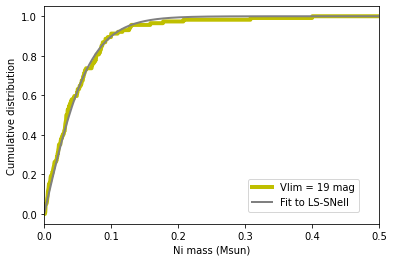

In [16]:
# Fit to Ni distribution of our SNe II sample.

from scipy.optimize import curve_fit

def fit_function(x,a):
    return np.tanh(a*x)


bins = np.linspace(0, 0.5, 1000)  
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

data_entries, bins_ = np.histogram(ni_avg_II, bins=bins)
tot_num = np.sum(data_entries)
cum = np.array([np.sum(data_entries[0:i])/tot_num for i in range(len(bins)-1)])

popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=cum, p0=[1.0])
print("Optimized parameter a0: ", popt)


plt.plot(binscenters, cum ,linewidth = 4.0, color = "y", label="Vlim = 19 mag")
plt.plot(binscenters, F(binscenters), label="Fit to LS-SNeII", color="gray", lw = 2)

plt.xlim(0,0.5)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.55, 0.3), loc='upper left', borderaxespad=2, fontsize=10)
plt.savefig('Ni_fit.png', bbox_inches="tight")

## Fit to tp vs 56Ni mass


In [63]:
def fit_tp_vs_Ni(which_Ni_mass):
    if which_Ni_mass=="arnett":
        x = np.log10(ni_meza_arnett_excluding_IcBL)
        y = tp_meza_excluding_IcBL 
    elif which_Ni_mass=="tail":
        x = np.log10(ni_meza_tail_dropna_excluding_IcBL)
        y = tp_meza_tail_dropna_excluding_IcBL 
    else:
        print("Error: which_Ni_mass should inapproproate.")
    
    # Fit. 
    a_coef, b_coef, a_err, b_err, y_err = least_square_fit(x, y)

    return a_coef, b_coef, a_err, b_err, y_err


def plot_fit_tp_vs_Ni(which_Ni_mass, save_file_name, a_coef, b_coef, tp_err, plot_USSNe_flag=False):
    '''
    Plot figures for fit.
    '''
    
    x_temp = np.arange(-2.,-0.1,0.001)
    y_temp = a_coef*x_temp + b_coef # lr.predict(x_temp) # coe[0]*x + coe[1]

    # attach error.
    y_up = y_temp + tp_err
    y_down = y_temp - tp_err

    if which_Ni_mass=="arnett":
        plt.scatter(np.log10(ni_meza_arnett_excluding_IcBL), tp_meza_excluding_IcBL, color="b", label = "w/o Ic-BL")
        plt.scatter(np.log10(ni_meza_arnett_IcBL), tp_meza_IcBL, color="b", facecolors='none', label = "Ic-BL")

    elif which_Ni_mass=="tail":
        plt.scatter(np.log10(ni_meza_tail_dropna_excluding_IcBL), tp_meza_tail_dropna_excluding_IcBL, color="cyan", label = "w/o Ic-BL")
        plt.scatter(np.log10(ni_meza_tail_dropna_IcBL), tp_meza_tail_dropna_IcBL, color="cyan", facecolors='none', label = "Ic-BL")

    else: # kk
        print("Error.")
     #   plt.scatter(np.log10(ni_meza_kk_excluding_IcBL), tp_meza_excluding_IcBL, color="g", label = "Not Ic-BL")
     #   plt.scatter(np.log10(ni_meza_kk_IcBL), tp_meza_IcBL, color="g", facecolors='none', label = "Ic-BL")


    if plot_USSNe_flag:
        #Data of USSNe:
        ni_USSNe = [0.016, 0.0500, 0.008, 0.038, 0.0157]
        tp_USSNe = [12, 7, 10, 5, 9]

        plt.scatter(np.log10(ni_avg_USSNe), tp_USSNe, s=80, color='magenta', marker = '*', alpha=1.0, label='USSNe candidates')

    plt.plot(x_temp, y_temp, color="black")
    plt.plot(x_temp, y_up, color="black", linestyle='dashed')
    plt.plot(x_temp, y_down, color="black", linestyle='dashed')
 
    plt.xlabel("log$_{10}$ Ni mass (Msun)")
    plt.ylabel("t$_p$ (day)")

    plt.ylim(5,35)

    plt.legend(bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0, fontsize=12)
    plt.savefig(save_file_name, bbox_inches="tight")     
    
    return

9.413935767493452 29.739386161695137 2.983396875360189 3.4178012993497973 4.052742560496027


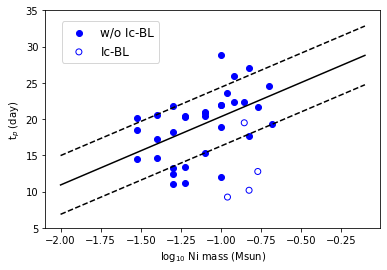

In [64]:
which_Ni_mass = "arnett" 
# Which methods of deriving Ni mass do you use when fitting tp vs Ni ?
# You can specify either "arnett" or "tail".


a_coef, b_coef, a_err, b_err, tp_err = fit_tp_vs_Ni(which_Ni_mass)

#a_coef, b_coef = 20, 40 # just try this value to test cadence code.

plot_fit_tp_vs_Ni(which_Ni_mass,'Ni_vs_tp_from_meza.png', a_coef, b_coef, tp_err, plot_USSNe_flag=False) 


print(a_coef, b_coef, a_err, b_err, tp_err)

You can check the result above by comparing the results to open-source *sklearn*.

In [19]:
### Consistency check ###

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

x = np.log10(ni_meza_arnett_excluding_IcBL) 
x = x[:,np.newaxis] 
y = tp_meza_excluding_IcBL 

lr.fit(x, y)                     

x_temp = np.arange(-2.,-0.1,0.001)
x_temp = x_temp[:,np.newaxis]
y_fit = lr.predict(x_temp) 

print("a_coef, b_coef (sklearn) :           ", lr.coef_[0], lr.intercept_)

#least_square_fit(X, Y)
print("a_coef, b_coef (our implementation): ", a_coef, b_coef)

print("")
if (a_coef - lr.coef_[0] < 1e-5) and (b_coef - lr.intercept_) < 1e-5 : 
    print("They give the same result!")
    
else:
    print("Error !")

#print("a_err, b_err =      ", a_err, b_err)

a_coef, b_coef (sklearn) :            9.413935767493456 29.739386161695144
a_coef, b_coef (our implementation):  9.413935767493452 29.739386161695137

They give the same result!


## Lpeak vs 56Ni mass

Compare observed Lpeak to the one estimated from the tp relation derived above. 

In [65]:
# Plot fit to Lp vs Ni mass derived using the fitting relation for tp.
# Error is calculated analyticallly.
def plot_Lp_vs_Ni(which_Ni_mass, save_file_name, a_coef, b_coef, tp_err, plot_USSNe_flag=False):
    
    plt.xlabel("Ni mass (Msun))")
    plt.ylabel("log L$_p$ (day)")

    ni_X_list = np.arange(0.01,1.0,0.001)

    tp_list = tp_for_M_Ni_using_fit_to_Meza(ni_X_list, a_coef, b_coef)
    Lp_tmp = Lpeak_for_tp_MNi(tp_list, ni_X_list)
    Lp_list = [np.log10(num) for num in Lp_tmp]

    plt.plot(np.log10(ni_X_list), Lp_list, color = 'black') # , label='Our prediction')


    if which_Ni_mass=="arnett":
        plt.scatter(np.log10(ni_meza_arnett_excluding_IcBL), lgL_meza_excluding_IcBL, color= 'b', label = "w/o Ic-BL")
        plt.scatter(np.log10(ni_meza_arnett_IcBL), lgL_meza_IcBL, color= 'b', facecolors='none', label = "Ic-BL")
    
    elif which_Ni_mass=="tail":
        plt.scatter(np.log10(ni_meza_tail_dropna_excluding_IcBL), lgL_meza_tail_dropna_excluding_IcBL, color="cyan", label = "w/o Ic-BL")
        plt.scatter(np.log10(ni_meza_tail_dropna_IcBL), lgL_meza_tail_dropna_IcBL, color="cyan", facecolors='none', label = "Ic-BL")

    else: # kk
        print("Error.")
        
    er = dlog10Lpeak_dtp(np.log10(ni_X_list), a_coef, b_coef)*tp_err

    Lp_list_up = Lp_list + er
    Lp_list_down = Lp_list - er
    plt.plot(np.log10(ni_X_list), Lp_list_up, color="black", linestyle='dashed')
    plt.plot(np.log10(ni_X_list), Lp_list_down, color="black", linestyle='dashed')

    #plt.xlim(0,0.3)
    #plt.ylim(10.0,20.0)
    plt.legend(bbox_to_anchor=(0.65, 0.25), loc='upper left', borderaxespad=0, fontsize=12)
    plt.savefig(save_file_name, bbox_inches="tight") 
    
    return ni_X_list, Lp_list_up, Lp_list_down

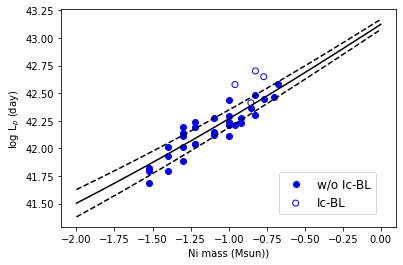

In [66]:
ni_X_list, Lp_list_up, Lp_list_down = plot_Lp_vs_Ni('arnett', 'Consistency_check_for_Lp.png', a_coef, b_coef, tp_err, plot_USSNe_flag=False)

Let us conduct a consisstency check for the result above by using a mock observation.

done


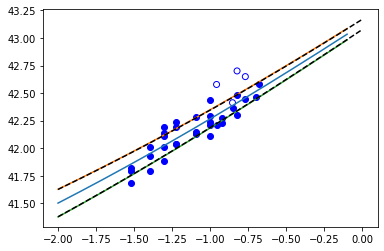

In [45]:
import statistics
import math

N_test = 1000
epsilon_random = np.random.normal(0, tp_err, N_test)
x_temp = np.arange(-2.,-0.1,0.001)
y_temp = a_coef*x_temp + b_coef # tp

logLp = np.zeros(len(x_temp))
logLp_err = np.zeros(len(x_temp))

for i in range(len(x_temp)): # Loop over x-coordinate.
    # We want to derive std of logLp for this x. Let us call this as std_x.
    l_keep = []
    x_ = x_temp[i]
    y_ = y_temp[i]
    logLp_ = 0
    logLp[i] = np.log10(Lpeak_for_tp_MNi(y_, 10**(x_)))
    
    for j in range(N_test):
        tp_ = y_ + epsilon_random[j]
       #print(tp_)
        logLp_ =  np.log10(Lpeak_for_tp_MNi(tp_, 10**(x_)))
        l_keep.append(logLp_)
    
    logLp_err[i] = statistics.stdev(l_keep) 
    
    
plt.scatter(np.log10(ni_meza_arnett_excluding_IcBL), lgL_meza_excluding_IcBL, color= 'b', label = "Not Ic-BL")
plt.scatter(np.log10(ni_meza_arnett_IcBL), lgL_meza_IcBL, color= 'b', facecolors='none', label = "Ic-BL")

plt.plot(x_temp, logLp)
plt.plot(x_temp, logLp + logLp_err)
plt.plot(x_temp, logLp - logLp_err)

# For comparison.
ni_X_list = np.arange(0.01,1.0,0.001)
plt.plot(np.log10(ni_X_list), Lp_list_up, color="black", linestyle='dashed')
plt.plot(np.log10(ni_X_list), Lp_list_down, color="black", linestyle='dashed')

print("done")

It seems that the results match quite well !

# Analysing data

## Comparing luminosity function and distance distribution

Here, we compare the luminosity function and distance distribution between SESNe and SNe II. 

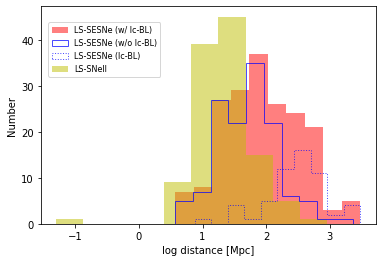

In [34]:
# Distribution of distance version2.

plt.xlabel("log distance [Mpc]")
plt.ylabel("Number")

plt.hist(np.log10(distance_SESNe), bins=10, alpha = 0.5, density = False,color="r", label = "LS-SESNe (w/ Ic-BL)")

plt.hist(np.log10(distance_SESNe_excluding_IcBL), bins=10, alpha = 0.7, 
         density = False, color="blue", label = "LS-SESNe (w/o Ic-BL)", histtype="step")
plt.hist(np.log10(distance_SESNe_IcBL), bins=10, alpha = 0.7, 
         density = False,color="blue", label = "LS-SESNe (Ic-BL)", histtype="step", linestyle='dotted')

plt.hist(np.log10(distance_II), bins=10, alpha = 0.5, density = False,color="y", label = "LS-SNeII")
plt.legend(bbox_to_anchor=(-0.025, 1), loc='upper left', borderaxespad=2, fontsize=8)
#plt.savefig('D_dist_all.png', bbox_inches="tight") 

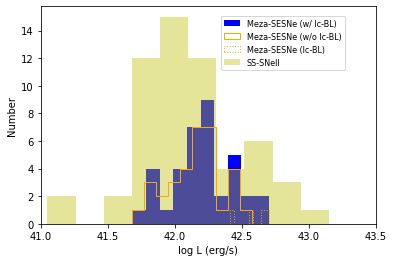

In [62]:
plt.hist(lgL_meza, bins=10, alpha = 1.0, density =False,color="b", label = "Meza-SESNe (w/ Ic-BL)") 
plt.hist(lgL_meza_excluding_IcBL, bins=10, alpha = 1.0, density =False,color="orange", label = "Meza-SESNe (w/o Ic-BL)", histtype="step") 
plt.hist(lgL_meza_IcBL, bins=10, alpha = 1.0, density =False,color="orange", 
        label = "Meza-SESNe (Ic-BL)", histtype="step", linestyle='dotted') 


plt.hist(lgL_avg_SSSNeII, bins=10, alpha = 0.4, density =False,color="y", label = "SS-SNeII") 

plt.xlabel("log L (erg/s)")
plt.ylabel("Number")
plt.xlim(41, 43.5)
plt.legend(bbox_to_anchor=(0.49, 1.03), loc='upper left', borderaxespad=2, fontsize=8)
plt.savefig('Lfunc_compare.png', bbox_inches="tight") 

## 56Ni mass distribution for different sizes of volumetric samples

[0.06410521739130436, 0.04430380952380953, 0.0412319587628866, 0.04433442622950819]


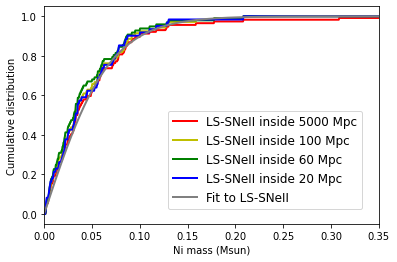

In [100]:

def cum_ni_hist(ni_cut, bins):
    data_entries, bins_ = np.histogram(ni_cut, bins=bins)
    tot = np.sum(data_entries)
    cum = np.array([np.sum(data_entries[0:i])/tot for i in range(len(bins)-1)])
    return cum

bins = np.linspace(0, 0.5, 1000) 
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

d_list = [5000.0, 100.0, 60.0, 20.0]
color_list = ['r', 'y', 'g', 'b']
ni_II_mean_list = []

for i, d_cut in enumerate(d_list):
    data_II_cut = data_II_new[data_II_new["Distance (Mpc)"]<=d_cut]
    ni_II_cut = data_II_cut['Average/single values'].values
    ni_II_mean_list.append(ni_II_cut.mean())
    cum = cum_ni_hist(ni_II_cut, bins)
    plt.plot(binscenters, cum, linewidth = 2.0, color = color_list[i], label="LS-SNeII inside %i Mpc" %d_cut)

# II fit.

plt.plot(binscenters, F(binscenters), linewidth = 2.0, color="gray", label="Fit to LS-SNeII") # anderson

plt.xlim(0,0.35)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.95, 0.52), loc='upper right', borderaxespad=0, fontsize=12)
plt.savefig('Ni_dist_different_d_cut_SNeII.png', bbox_inches="tight")

print(ni_II_mean_list)

[0.27945077, 0.15919039, 0.1364961, 0.14242499]
[0.17737557, 0.14894536, 0.1273014, 0.14445184]


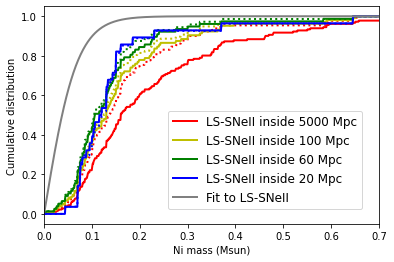

In [107]:
bins = np.linspace(0, 1.0, 1000) # not the same as SNe II.
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

d_list = [5000.0, 100.0, 60.0, 20.0]
color_list = ['r', 'y', 'g', 'b']
ni_SESNe_mean_list = []
ni_SESNe_excluding_IcBL_mean_list = []

# Set whether separate Ic-BL in your plot. 
separate_IcBL_flag = True 

if separate_IcBL_flag:
    for i, d_cut in enumerate(d_list):
        ni_SESNe_cut = ni_avg_SESNe[distance_SESNe <= d_cut]
        ni_SESNe_excluding_IcBL_cut = ni_avg_SESNe_excluding_IcBL[distance_SESNe_excluding_IcBL <= d_cut]
        
        ni_SESNe_mean_list.append(ni_SESNe_cut.mean())
        ni_SESNe_excluding_IcBL_mean_list.append(ni_SESNe_excluding_IcBL_cut.mean())
        
        cum = cum_ni_hist(ni_SESNe_cut, bins)
        cum_excluding_IcBL = cum_ni_hist(ni_SESNe_excluding_IcBL_cut, bins)
        
        plt.plot(binscenters, cum, linewidth = 2.0, color = color_list[i], label="LS-SNeII inside %i Mpc" %d_cut)
        plt.plot(binscenters, cum_excluding_IcBL, linewidth = 2.0, color = color_list[i], linestyle = 'dotted', label="")

else:
    for i, d_cut in enumerate(d_list):
        ni_SESNe_cut = ni_avg_SESNe[distance_SESNe <= d_cut]
        ni_SESNe_mean_list.append(ni_SESNe_cut.mean())
        cum = cum_ni_hist(ni_SESNe_cut, bins)
        plt.plot(binscenters, cum, linewidth = 2.0, color = color_list[i], label="LS-SNeII inside %i Mpc" %d_cut)


# II fit.
plt.plot(binscenters, F(binscenters), linewidth = 2.0, color="gray", label="Fit to LS-SNeII") # anderson

plt.xlim(0,0.7)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.95, 0.52), loc='upper right', borderaxespad=0, fontsize=12)
plt.savefig('Ni_dist_different_d_cut_SESNe.png', bbox_inches="tight") 

print(ni_SESNe_mean_list)
print(ni_SESNe_excluding_IcBL_mean_list)

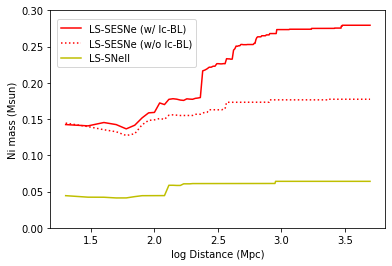

In [67]:
# Plot mean 56Ni mass as a function of distance.

l_dist = np.arange(20,5000,10)

l_ni_II = []
l_ni_SESNe = []
l_ni_SESNe_excluding_IcBL = []
sepate_IcBL = True

for d in l_dist:
    ni_SESNe_all_cut = ni_avg_SESNe[distance_SESNe <= d]
    
    data_II_all_cut = data_II_new[data_II_new["Distance (Mpc)"]<=d] 
    ni_II_all_cut = data_II_all_cut['Average/single values'].values

    l_ni_SESNe.append(ni_SESNe_all_cut.mean())
    l_ni_II.append(ni_II_all_cut.mean())
    
    if sepate_IcBL:
        ni_SESNe_new_excluding_IcBL_cut = ni_avg_SESNe_excluding_IcBL[distance_SESNe_excluding_IcBL <= d]
        l_ni_SESNe_excluding_IcBL.append(ni_SESNe_new_excluding_IcBL_cut.mean())


plt.xlabel("log Distance (Mpc)")
plt.ylabel("Ni mass (Msun)")

plt.ylim(0,0.3)

plt.plot(np.log10(l_dist),l_ni_SESNe, label="LS-SESNe (w/ Ic-BL)",color="r")
plt.plot(np.log10(l_dist),l_ni_SESNe_excluding_IcBL, label="LS-SESNe (w/o Ic-BL)",color="r", linestyle="dotted")
plt.plot(np.log10(l_dist),l_ni_II, label="LS-SNeII",color="y")

plt.legend(bbox_to_anchor=(-0.04, 1.05), loc='upper left', borderaxespad=2, fontsize=10)
plt.savefig('Ni_volume_limited.png', bbox_inches="tight") 

## Luminosity vs distance

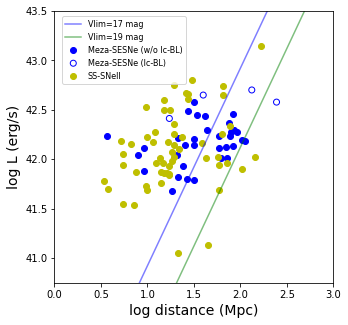

In [71]:
# PYTHON_MATPLOTLIB_CONTOUR_01

import numpy as np
import matplotlib.pyplot as plt

# Figureを作成
fig = plt.figure(figsize = (5, 5))

# FigureにAxesを追加
ax = fig.add_subplot(111)

# 軸ラベルを設定
ax.set_xlabel("log distance (Mpc)", size = 14)
ax.set_ylabel("log L (erg/s)", size = 14)

# 軸の範囲を設定
ax.set_xlim(0.0, 3.0)
ax.set_ylim(40.75, 43.5)

ax.scatter(np.log10(distance_meza_excluding_IcBL),lgL_meza_excluding_IcBL, color="b", label = "Meza-SESNe (w/o Ic-BL)")
ax.scatter(np.log10(distance_meza_IcBL),lgL_meza_IcBL, color="b", facecolors='none', label = "Meza-SESNe (Ic-BL)")
#ax.scatter(np.log10(distance_connect_3papers), lgL_connect_3papers, color="y", label = "SS-SNeII") # : Hamuy (2003) & Pejcha & Prieto (2015)")
ax.scatter(np.log10(distance_SSSNeII), lgL_avg_SSSNeII, color="y", label = "SS-SNeII") # : Hamuy (2003) & Pejcha & Prieto (2015)")


x_l =  np.arange(0.0,5.0,1)

# lgL = 2lgD - 0.4*Vlim -16.28/5
Vlim_plt  = 17. 
plt.plot(2*x_l-0.4*Vlim_plt - 16.28/5.0 + 2*np.log10(pc)+12., label="Vlim=17 mag", color='b', alpha=0.5) # 最後の項はDMpc-Dcmの変換。
#plt.plot(2*(x_l-0.85)+41.)

Vlim_plt  = 19. 
plt.plot(2*x_l-0.4*Vlim_plt - 16.28/5.0 + 2*np.log10(pc)+12., label="Vlim=19 mag", color='g', alpha=0.5) # 最後の項はDMpc-Dcmの変換。

plt.legend(bbox_to_anchor=(-0.03, 1.04), loc='upper left', borderaxespad=2, fontsize=8)
plt.savefig('Lpeak_dist.png', bbox_inches="tight") 

## 56Ni mass vs distance


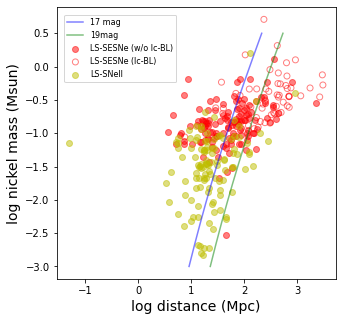

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Figureを作成
fig = plt.figure(figsize = (5, 5))

# FigureにAxesを追加
ax = fig.add_subplot(111)

# 軸ラベルを設定
ax.set_xlabel("log distance (Mpc)", size = 14)
ax.set_ylabel("log nickel mass (Msun)", size = 14)

# 軸の範囲を設定
#### ax.set_xlim(0.0, 3.0)
#ax.set_ylim(0, 0.3)

logNi_list = np.arange(-3.0,0.5,0.0001)
logL_tmp= np.log10(Lpeak_for_MNi_direct(10**logNi_list, a_coef, b_coef).astype(np.float64)) 
    # Lpeak_for_M_Ni(10**logNi_list)) + logNi_list + 43.0
logd_lim_list = np.log10(D_lim(logL_tmp,17))
ax.plot(logd_lim_list,logNi_list,label='17 mag', color = 'b', alpha=0.5)
logd_lim_list = np.log10(D_lim(logL_tmp,19))
ax.plot(logd_lim_list,logNi_list,label='19mag', color = 'g', alpha=0.5)

ax.scatter(np.log10(distance_SESNe_excluding_IcBL),np.log10(ni_avg_SESNe_excluding_IcBL), color="r", alpha=0.5, label = "LS-SESNe (w/o Ic-BL)") #: Meza & Anderson (2020)")
ax.scatter(np.log10(distance_SESNe_IcBL),np.log10(ni_avg_SESNe_IcBL), color="r", alpha=0.5, facecolor='none', label = "LS-SESNe (Ic-BL)") #: Meza & Anderson (2020)")
ax.scatter(np.log10(distance_II),np.log10(ni_avg_II), alpha=0.5, color="y", label = "LS-SNeII") # : Hamuy (2003) & Pejcha & Prieto (2015)")

plt.legend(bbox_to_anchor=(-0.03, 1.03), loc='upper left', borderaxespad=2, fontsize=8)
plt.savefig('Ni_vs_distance.png', bbox_inches="tight") 

# Mock observation

Below, we are going to conduct mock observations with various kinds of condition. 

## Define functions for mock observations

In [19]:
def Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, seed, Vlim_inf_flag, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim):
    '''
    Conduct a mock observation for a given limiting magnitude Vlim.
    
    Argument:
    - Vlim: limitng magnitude
    - N_iter: the number of iteration
    - num_detect: stop one iteration onece num of detection reaches this number.
    - Dmax: distance outer boundary for mock observation.
    - seed: random seed
    - t_cadence: observational cadence. Usually assume 0.
    - Vlim_inf_flag: if true, detect everything regardless of its luminosity and distance.
    - ni_obs_diff_Vlim: 56Ni mass for detect samples. Shape is (len(Vlim_list), N_iter, num_detect))
    - lgL_obs_diff_Vlim: lgLpeak mass for detect samples. Shape is (len(Vlim_list), N_iter, num_detect))
    - Dist_obs_diff_Vlim: Distance for detect samples. Shape is (len(Vlim_list), N_iter, num_detect))
    
    Return:
    '''         
    # Create random distance at the beginning (This runs much faster than creating ranndom number each time). 
    r = powerlaw.rvs(4, size= N_events_maximum, random_state=l) # prob func = 4*x^3
    ni_rand_tmp_list = np.arctanh(np.random.rand(N_events_maximum))/a0
    
    # Take tp from a normal distribution derived in the fit to tp vs Ni mass.
    # !!!!!!!!!!!!!! Be careful! Use log10 for Ni mass!!!!!!!!!!!
    tp_tmp_list = np.random.normal(loc= a_coef*np.log10(ni_rand_tmp_list) + b_coef, scale = tp_err) 
    
    lgL_tmp_list = np.log10(Lpeak_for_tp_MNi(tp_tmp_list, ni_rand_tmp_list).astype(np.float64)) #.astype(np.float64)
    
    assert ni_rand_tmp_list.shape == tp_tmp_list.shape
    assert tp_tmp_list.shape == lgL_tmp_list.shape
    
    # if you want NOT to take the error bar of tp into account.
    #lgL_tmp_list = np.log10(Lpeak_for_MNi_direct(ni_rand_tmp_list, a_coef, b_coef).astype(np.float64))
    
    D_lim_tmp_list = D_lim(lgL_tmp_list,Vlim)        
    

    if N_iter==1: # Maybe this is a bit ad-hoc.
        ni_all_events, Dist_all_events = Mockobs_for_non_inf_Vlim_return_non_detected_events(
            Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, 
            r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, 
            ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim)
        return ni_all_events, Dist_all_events
    
    elif t_cadence == 0:
        if Vlim_inf_flag == True: # When Vlim = inf
            Mockobs_for_inf_Vlim(
                Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, 
                r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, 
                ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim
            )
    
        else: # Not Vlim = inf 
            Mockobs_for_non_inf_Vlim(
                Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, 
                r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list,
                ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim
            )
            
        return
        
    else: # when t_cade != 0
        Mockobs_for_non_inf_Vlim_with_cadence(Vlim, t_cadence, tp_tmp_list, N_iter, N_events_maximum, num_detect, Dmax, seed, r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim)

        return 

    return

def Mockobs_for_inf_Vlim(Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim):
    print("------------------------")
    print("Start mock observation for Vlim = infinity")
    print("Random seed = ", seed)

    random.seed(seed)
     
    for iter in range(N_iter):
        count = 0
        num_events = 0
        for i in range(N_events_maximum):
            num_events+=1

            r_tmp = random.choice(r) # powerlaw.rvs(4, size=1) # prob func = 4*x^3                                                                                                                                                                                   
            D_rand_tmp = r_tmp*Dmax
            id_tmp = random.randint(0, N_events_maximum-1)
            ni_rand_tmp = ni_rand_tmp_list[id_tmp]
            lgL_tmp = lgL_tmp_list[id_tmp]
            D_lim_tmp = D_lim_tmp_list[id_tmp]

            # Detect everything !
            ni_obs_diff_Vlim[l][iter][count] = ni_rand_tmp
            lgL_obs_diff_Vlim[l][iter][count] = lgL_tmp
            Dist_obs_diff_Vlim[l][iter][count] = D_rand_tmp

            count += 1
            if count >= num_detect:
                break

        # Make sure that every events are detected.
        assert num_events == num_detect
    print("Finished mock observation for Vlim = inifinity")
    return 

def Mockobs_for_non_inf_Vlim(Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim):

    print("------------------------")
    print("Start mock observation for Vlim = ", Vlim)
    print("Dmax = ", Dmax)
    print("Random seed = ", seed)

    random.seed(seed)
     
    for iter in range(N_iter):
        count = 0
        num_events = 0
        for i in range(N_events_maximum):
            num_events+=1

            r_tmp = random.choice(r) # powerlaw.rvs(4, size=1) # prob func = 4*x^3                                                                                                                                                                                   
            D_rand_tmp = r_tmp*Dmax
            id_tmp = random.randint(0, N_events_maximum-1)
            ni_rand_tmp = ni_rand_tmp_list[id_tmp]
            lgL_tmp = lgL_tmp_list[id_tmp]
            D_lim_tmp = D_lim_tmp_list[id_tmp]

            if (D_rand_tmp <= D_lim_tmp): # Detect!                                                                                                                                                                                           
                ni_obs_diff_Vlim[l][iter][count] = ni_rand_tmp
                lgL_obs_diff_Vlim[l][iter][count] = lgL_tmp
                Dist_obs_diff_Vlim[l][iter][count] = D_rand_tmp

                count += 1
                if count >= num_detect:
                    break

        # Make sure that num of detection is 100.
        #print(count, num_detect)
        assert count==num_detect

    print("Finished mock observation for Vlim = ", Vlim)
    return 


def Mockobs_for_non_inf_Vlim_with_cadence(Vlim, t_cadence, tp_tmp_list, N_iter, N_events_maximum, num_detect, Dmax, seed, r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim):

    print("------------------------")
    print("Start mock observation for Vlim = ", Vlim)
    print("Dmax = ", Dmax)
    print("Random seed = ", seed)
    
    random.seed(seed)
    
    for iter in range(N_iter):
        count = 0
        num_events = 0
        for i in range(N_events_maximum):
            num_events+=1

            r_tmp = random.choice(r) # powerlaw.rvs(4, size=1) # prob func = 4*x^3                                                                                                                                                                                   
            D_rand_tmp = r_tmp*Dmax
            id_tmp = random.randint(0, N_events_maximum-1)
            ni_rand_tmp = ni_rand_tmp_list[id_tmp]
            lgL_tmp = lgL_tmp_list[id_tmp]
            D_lim_tmp = D_lim_tmp_list[id_tmp]

            tp_tmp = tp_tmp_list[id_tmp]
            
      #      tau_tmp = tp_for_M_Ni_using_fit_to_Meza(ni_rand_tmp, a_coef, b_coef)
            prob_catch = min([tp_tmp/t_cadence, 1.0])
            rd = random.random() # 0.0~1.0
            
        #    print("rd = ",rd, " prob_catch = ", prob_catch)
        #    print("tp_tmp = ", tp_tmp, "t_cadence = ", t_cadence)
            
            if (D_rand_tmp <= D_lim_tmp and rd<prob_catch): # Detect!  
                ni_obs_diff_Vlim[l][iter][count] = ni_rand_tmp
                lgL_obs_diff_Vlim[l][iter][count] = lgL_tmp
                Dist_obs_diff_Vlim[l][iter][count] = D_rand_tmp

                count += 1
                if count >= num_detect:
                    break

        # Make sure that num of detection is 100.
        #print(count, num_detect)
        assert count==num_detect

    print("Finished mock observation for Vlim = ", Vlim)
    return 


def Mockobs_for_non_inf_Vlim_return_non_detected_events(Vlim, N_iter, N_events_maximum, num_detect, Dmax, seed, r, ni_rand_tmp_list, lgL_tmp_list, D_lim_tmp_list, ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim):

    print("------------------------")
    print("Start mock observation for Vlim = ", Vlim)
    print("Dmax = ", Dmax)
    print("Random seed = ", seed)

    random.seed(seed)
     
    ###
    ni_all_events = []   
    Dist_all_events = [] 
    ###
    
    for iter in range(N_iter):
        count = 0
        num_events = 0
        for i in range(N_events_maximum):
            num_events+=1

            r_tmp = random.choice(r) # powerlaw.rvs(4, size=1) # prob func = 4*x^3                                                                                                                                                                                   
            D_rand_tmp = r_tmp*Dmax
            id_tmp = random.randint(0, N_events_maximum-1)
            ni_rand_tmp = ni_rand_tmp_list[id_tmp]
            lgL_tmp = lgL_tmp_list[id_tmp]
            D_lim_tmp = D_lim_tmp_list[id_tmp]
            
            ni_all_events.append(ni_rand_tmp)
            Dist_all_events.append(D_rand_tmp)

            if (D_rand_tmp <= D_lim_tmp): # Detect!                                                                                                                                                                                           
                ni_obs_diff_Vlim[l][iter][count] = ni_rand_tmp
                lgL_obs_diff_Vlim[l][iter][count] = lgL_tmp
                Dist_obs_diff_Vlim[l][iter][count] = D_rand_tmp

                count += 1
                if count >= num_detect:
                    break

        # Make sure that num of detection is 100.
        #print(count, num_detect)
        assert count==num_detect

    print("Finished mock observation for Vlim = ", Vlim)
    return ni_all_events, Dist_all_events



In [20]:
def calculate_mean_and_std(array, bins):
    '''
    Calculate mean and standard deviation for arraies, such as 56Ni and lgL of detected events.
    
    Arguments:
    - array (e.g. ni_obs_diff_Vlim) : 56Ni mass for detect samples. Shape is (len(Vlim_list), N_iter, num_detect))
    
    Return:
    
    '''
    num_bins = len(bins) # 50

    # initialize
    data_entries = np.zeros((array.shape[0], N_iter,num_bins-1))
    
    mean_array_bin = np.zeros((array.shape[0],num_bins-1))
    std_array_bin = np.zeros((array.shape[0],num_bins-1))
  
    cum = np.zeros((array.shape[0], array.shape[1], num_bins-1))

    for l in range(array.shape[0]): # iterate for Vlim
        for i in range(array.shape[1]):
            data_entries[l,i,:], _ = np.histogram(array[l,i,:], bins=bins)
            tot_num = np.sum(data_entries[l,i,:])
            cum[l,i,:] = np.array([np.sum(data_entries[l,i,0:j])/tot_num for j in range(len(bins)-1)])
    
    mean_array_bin = np.mean(data_entries, axis=1)
    std_array_bin  = np.std(data_entries, axis=1)
    
    mean_array_cum_bin = np.mean(cum, axis=1)
    std_array_cum_bin  = np.std(cum, axis=1)
    
    assert mean_array_bin.shape == (array.shape[0], num_bins-1) 
    assert std_array_bin.shape == (array.shape[0], num_bins-1) 
    
    assert mean_array_cum_bin.shape == (array.shape[0], num_bins-1) 
    assert std_array_cum_bin.shape == (array.shape[0], num_bins-1) 
        
    return mean_array_bin, std_array_bin, mean_array_cum_bin, std_array_cum_bin

In [23]:
ni_rand_tmp_list = np.arctanh(np.random.rand(N_events_maximum))/a0
    
# Take tp from a normal distribution derived in the fit to tp vs Ni mass.
tp_tmp_list = a_coef*np.log10(ni_rand_tmp_list) + b_coef # np.random.normal(loc= a_coef*ni_rand_tmp_list + b_coef, scale = tp_err)
lgL_tmp_list = np.log10(Lpeak_for_tp_MNi(tp_tmp_list, ni_rand_tmp_list).astype(np.float64)) #.astype(np.float64)
    
for i in range(50):
    print(ni_rand_tmp_list[i])
    print(tp_tmp_list[i])
    print("")

0.04222585737757745
16.800670221932215

0.0614697817702518
18.335924942546825

0.047758064052102284
17.30401677233788

0.04184192371966156
16.763326709939236

0.030959095460866816
15.531763812974239

0.052602186689911436
17.698998071939045

0.03213030356506554
15.683578264221827

0.09795149956524828
20.240829364463544

0.1365935347034454
21.600381067432128

0.02766900003728376
15.072412705916234

0.0736791708711681
19.076642203198055

0.040303680157330754
16.610190784398327

0.04413961818869256
16.98188938605847

0.11138758933704296
20.76636906799471

0.004872235591523097
7.971808712230999

0.005981142675844339
8.810175068475871

0.0013845965326695186
2.8279867602899387

0.0819355801227018
19.510886377385216

0.07125820022765626
18.9400471169195

0.09128295594011089
19.952561527532197

0.1550091579346346
22.117462326135687

0.07506518272915746
19.152836868343464

0.034180830361261634
15.936509820786384

0.071671948467157
18.9637171608587

0.008136650184795837
10.068455680822268

0.0519

## Effect of different limiting magnitude Vlim.

First, let us conduct mock observation for Different limiting magnitude Vlim.

Here, we assume 
- infinitely small cadence

In [24]:
# Define global parameters for mock obsevations.

N_iter = 1000 # Number of iteration                                                                                                                                                                                                                         
num_detect = 100 # Stop one iteration once the detected number reaches this number                                                                                                                                                                                                           
N_events_maximum = 100000 # Maximum number of events.
t_cadence = 0 # osbervational cadence. 0 otherwise noted.

num_bins_lgL = 100 # 50 
bins_lgL = np.linspace(39, 44, num_bins_lgL)
binscenters_lgL = np.array([0.5*(bins_lgL[i] + bins_lgL[i+1]) for i in range(len(bins_lgL)-1)])

num_bins_ni = 100 # 50
bins_ni = np.linspace(0, 0.5, num_bins_ni)
binscenters_ni = np.array([0.5*(bins_ni[i] + bins_ni[i+1]) for i in range(len(bins_ni)-1)])

num_bins_dist = 100 # 50
bins_dist = np.linspace(0, 500, num_bins_dist)

num_bins_cadence = 100 # 50
bins_cadence = np.linspace(0, 0.5, num_bins_cadence)




Ni_lim = 1.0 # Limiting Ni mass (Msun). This determines the outer distance boundary.


In [25]:
# mock observation for Different limiting magnitude Vlim.

Vlim_list = [21.0, 19.0, 17.0] # Different limiting magnitude you want to try.

# Arraies for the properties of detect samples.
ni_obs_diff_Vlim = np.zeros((len(Vlim_list), N_iter,num_detect))
lgL_obs_diff_Vlim = np.zeros((len(Vlim_list), N_iter,num_detect))
Dist_obs_diff_Vlim = np.zeros((len(Vlim_list), N_iter,num_detect))

# Make sure the size of list is correct.
assert ni_obs_diff_Vlim.shape == (len(Vlim_list), N_iter, num_detect)
assert lgL_obs_diff_Vlim.shape == (len(Vlim_list), N_iter, num_detect)
assert Dist_obs_diff_Vlim.shape == (len(Vlim_list), N_iter, num_detect)

print("which_Ni_mass = ", which_Ni_mass)

for l in range(len(Vlim_list)):
    Vlim = Vlim_list[l]
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    
    start = time.time()  
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False , ni_obs_diff_Vlim, lgL_obs_diff_Vlim, Dist_obs_diff_Vlim)
    elapsed_time = time.time() - start
    
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("------------------------")
print("Finished all calculations !") 

which_Ni_mass =  arnett
------------------------
Start mock observation for Vlim =  21.0
Dmax =  795.2990000155829
Random seed =  0
Finished mock observation for Vlim =  21.0
elapsed_time:85.85186791419983[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  1
Finished mock observation for Vlim =  19.0
elapsed_time:85.69722008705139[sec]
------------------------
Start mock observation for Vlim =  17.0
Dmax =  126.04639710958368
Random seed =  2
Finished mock observation for Vlim =  17.0
elapsed_time:87.8538601398468[sec]
------------------------
Finished all calculations !


In [26]:
# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_bin, std_ni_bin, mean_ni_cum_bin, std_ni_cum_bin = calculate_mean_and_std(ni_obs_diff_Vlim, bins_ni)

# log Lpeak
mean_lgL_bin, std_lgL_bin, _, _ = calculate_mean_and_std(lgL_obs_diff_Vlim, bins_lgL)

# Distance
mean_distance_bin, std_distance_bin, _, _ = calculate_mean_and_std(Dist_obs_diff_Vlim, bins_dist)

Next, we conduct a mock observation assuming a infinity large limiting magnitude. 

In [27]:
Vlim_inf_flag= True

ni_obs_Vlim_inf = np.zeros((3, N_iter,num_detect))
lgL_obs_Vlim_inf = np.zeros((3, N_iter,num_detect))
Dist_obs_Vlim_inf = np.zeros((3, N_iter,num_detect))


Vlim_list = [21.0, 19.0, 17.0] # Different limiting magnitude you want to try.
Dmax_list = [D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim) for Vlim in Vlim_list]
# In previous manuscript, I used, [30, 100, 300] 

start = time.time()
for l in range(len(Vlim_list)): # Iterate three times.
    Vlim = Vlim_list[l]
    Dmax = Dmax_list[l]
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, True, ni_obs_Vlim_inf, lgL_obs_Vlim_inf, Dist_obs_Vlim_inf)
    
elapsed_time = time.time() - start

print("------------------------")
print("Finished all calculations !")
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

------------------------
Start mock observation for Vlim = infinity
Random seed =  0
Finished mock observation for Vlim = inifinity
------------------------
Start mock observation for Vlim = infinity
Random seed =  1
Finished mock observation for Vlim = inifinity
------------------------
Start mock observation for Vlim = infinity
Random seed =  2
Finished mock observation for Vlim = inifinity
------------------------
Finished all calculations !
elapsed_time:3.4716861248016357[sec]


In [28]:
# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_inf_bin, std_ni_inf_bin, mean_ni_inf_cum_bin, std_ni_inf_cum_bin = calculate_mean_and_std(ni_obs_Vlim_inf, bins_ni)

# log Lpeak
mean_lgL_inf_bin, std_lgL_inf_bin, _, _ = calculate_mean_and_std(lgL_obs_Vlim_inf, bins_lgL)

In [29]:
# サンプル数が37の場合
# Vlim=19におけるmock観測 

N_iter = 1000 # 10000                                                                                                                                                                                                                            
num_detect = 37 # 189 #150                                                                                                                                                                                                                   

ni_obs_Vlim_19_sample_37 = np.zeros((1, N_iter,num_detect))
lgL_obs_Vlim_19_sample_37 = np.zeros((1, N_iter,num_detect))
Dist_obs_Vlim_19_sample_37 = np.zeros((1, N_iter,num_detect))
                                                                                                                                                            
Vlim_list = [19.0]

start = time.time()

for l in range(1):
    Vlim = Vlim_list[l]
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    assert num_detect == 37
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False, ni_obs_Vlim_19_sample_37, lgL_obs_Vlim_19_sample_37, Dist_obs_Vlim_19_sample_37)
    
    
# Vlim=infにおけるmock観測                             
Vlim_inf_flag= True

ni_obs_Vlim_inf_sample_37 = np.zeros((1, N_iter,num_detect))
lgL_obs_Vlim_inf_sample_37 = np.zeros((1, N_iter,num_detect))
Dist_obs_Vlim_inf_sample_37 = np.zeros((1, N_iter,num_detect))                           

for l in range(1):
    assert Vlim_inf_flag == True
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), 19.) # Use 19.
    Mockobs_for_a_given_Vlim(19, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, True, ni_obs_Vlim_inf_sample_37, lgL_obs_Vlim_inf_sample_37, Dist_obs_Vlim_inf_sample_37)
    
elapsed_time = time.time() - start

print("------------------------")
print("Finished all calculations !")
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  0
Finished mock observation for Vlim =  19.0
------------------------
Start mock observation for Vlim = infinity
Random seed =  0
Finished mock observation for Vlim = inifinity
------------------------
Finished all calculations !
elapsed_time:40.67638397216797[sec]


In [30]:
# Take the mean and std of N_iter iterations.

# log Lpeak
mean_lgL_37_bin, std_lgL_37_bin, _, _ = calculate_mean_and_std(lgL_obs_Vlim_19_sample_37, bins_lgL)
mean_lgL_37_inf_bin, std_lgL_37_inf_bin, _, _ = calculate_mean_and_std(lgL_obs_Vlim_inf_sample_37, bins_lgL)

In [31]:
# mock observation for Different limiting magnitude Vlim.

Vlim_list = [21.0, 19.0, 17.0] # Different limiting magnitude you want to try.

# Arraies for the properties of detect samples.
ni_obs_diff_Vlim_Dmax_close = np.zeros((len(Vlim_list), N_iter,num_detect))
lgL_obs_diff_Vlim_Dmax_close = np.zeros((len(Vlim_list), N_iter,num_detect))
Dist_obs_diff_Vlim_Dmax_close = np.zeros((len(Vlim_list), N_iter,num_detect))

# Make sure the size of list is correct.
assert ni_obs_diff_Vlim_Dmax_close.shape == (len(Vlim_list), N_iter, num_detect)
assert lgL_obs_diff_Vlim_Dmax_close.shape == (len(Vlim_list), N_iter, num_detect)
assert Dist_obs_diff_Vlim_Dmax_close.shape == (len(Vlim_list), N_iter, num_detect)

print("which_Ni_mass = ", which_Ni_mass)

Dmax = 80 
for l in range(len(Vlim_list)):
    Vlim = Vlim_list[l]
   # Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    
    start = time.time()  
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False , ni_obs_diff_Vlim_Dmax_close, lgL_obs_diff_Vlim_Dmax_close, Dist_obs_diff_Vlim_Dmax_close)
    elapsed_time = time.time() - start
    
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("------------------------")
print("Finished all calculations !") 


# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_Dmax_close_bin, std_ni_Dmax_close_bin, mean_ni_cum_Dmax_close_bin, std_ni_cum_Dmax_close_bin = calculate_mean_and_std(ni_obs_diff_Vlim_Dmax_close, bins_ni)

which_Ni_mass =  arnett
------------------------
Start mock observation for Vlim =  21.0
Dmax =  80
Random seed =  0
Finished mock observation for Vlim =  21.0
elapsed_time:0.4869809150695801[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  80
Random seed =  1
Finished mock observation for Vlim =  19.0
elapsed_time:0.7184047698974609[sec]
------------------------
Start mock observation for Vlim =  17.0
Dmax =  80
Random seed =  2
Finished mock observation for Vlim =  17.0
elapsed_time:6.957520961761475[sec]
------------------------
Finished all calculations !


## Effect of different observational cadence

In [100]:
# 異なるcadenceにおけるmock観測
# Vlim = 19 mag
# 検出数は100

N_iter = 1000 # 10000                                                                                                                                                                                                                            
num_detect = 100 # 189 #150 
   
start = time.time()

ni_obs_diff_cadence = np.zeros((3, N_iter,num_detect))
lgL_obs_diff_cadence = np.zeros((3, N_iter,num_detect))
Dist_obs_diff_cadence = np.zeros((3, N_iter,num_detect))

cadence_list = [1., 10, 30.]# [5.0, 10.0, 20.0] # [10.0, 20.0, 30.0]
Vlim = 19.0

for l in range(3):
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    t_cadence = cadence_list[l]
    start=time.time()
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False, ni_obs_diff_cadence, lgL_obs_diff_cadence, Dist_obs_diff_cadence)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print("done")

# 280.4080970287323[sec]

------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  0
Finished mock observation for Vlim =  19.0
elapsed_time:102.48842406272888[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  1
Finished mock observation for Vlim =  19.0
elapsed_time:101.57989287376404[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  2
Finished mock observation for Vlim =  19.0
elapsed_time:170.73882794380188[sec]
done


In [101]:
# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_cadence_bin, std_ni_cadence_bin, mean_ni_cadence_cum_bin, std_ni_cadence_cum_bin = calculate_mean_and_std(ni_obs_diff_cadence, bins_ni)

# log Lpeak
mean_lgL_cadence_bin, std_lgL_cadence_bin, _, _ = calculate_mean_and_std(lgL_obs_diff_cadence, bins_lgL)

In [50]:
# 異なるcadenceにおけるmock観測
# Vlim = 19 mag
# 検出数は100

N_iter = 1000 # 10000                                                                                                                                                                                                                            
num_detect = 100 # 189 #150 
   
start = time.time()

ni_obs_diff_cadence_Dmax_close = np.zeros((3, N_iter,num_detect))
lgL_obs_diff_cadence_Dmax_close = np.zeros((3, N_iter,num_detect))
Dist_obs_diff_cadence_Dmax_close = np.zeros((3, N_iter,num_detect))

#cadence_list = [5.0, 10.0, 20.0] # [10.0, 20.0, 30.0]
Vlim = 19.0

Dmax = 80 
for l in range(len(cadence_list)):
    # Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    t_cadence = cadence_list[l]
    start=time.time()
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False, ni_obs_diff_cadence_Dmax_close, lgL_obs_diff_cadence_Dmax_close, Dist_obs_diff_cadence_Dmax_close)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print("done")

# 280.4080970287323[sec]

# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_different_cadence_Dmax_close_bin, std_ni_different_cadence_Dmax_close_bin, mean_ni_different_cadence_cum_Dmax_close_bin, std_ni_different_cadence_cum_Dmax_close_bin = calculate_mean_and_std(ni_obs_diff_cadence_Dmax_close, bins_ni)

------------------------
Start mock observation for Vlim =  19.0
Dmax =  80
Random seed =  0
Finished mock observation for Vlim =  19.0
elapsed_time:2.213951826095581[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  80
Random seed =  1
Finished mock observation for Vlim =  19.0
elapsed_time:3.349256992340088[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  80
Random seed =  2
Finished mock observation for Vlim =  19.0
elapsed_time:1.921416997909546[sec]
done


## Plot result

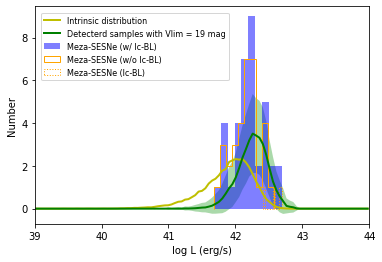

In [80]:
# Compare luminosity function to data.

# Better to make errorbars contour?

plt.xlim(39,44)

plt.xlabel("log L (erg/s)")
plt.ylabel("Number")

#plt.hist(lgL_meza, bins=10, alpha = 1.0, density =False,color="b", label = "Meza-SESNe") 
plt.hist(lgL_meza, bins=10, alpha = 0.5, density =False,color="b", label = "Meza-SESNe (w/ Ic-BL)") 
plt.hist(lgL_meza_excluding_IcBL, bins=10, alpha = 1.0, density =False,color="orange", label = "Meza-SESNe (w/o Ic-BL)", histtype="step") 
plt.hist(lgL_meza_IcBL, bins=10, alpha = 1.0, density =False,color="orange", 
        label = "Meza-SESNe (Ic-BL)", histtype="step", linestyle='dotted') 


plt.plot(binscenters_lgL, mean_lgL_37_inf_bin[0,:],linewidth = 2.0, color = "y", label="Intrinsic distribution")

#plt.errorbar(binscenters_lgL, mean_lgL_37_bin[0,:], yerr=std_lgL_37_bin[0,:],linewidth = 2.0, color = "g", label="Detecterd samples with Vlim = 19 mag")
plt.plot(binscenters_lgL, mean_lgL_37_bin[0,:],linewidth = 2.0, color = "g", label="Detecterd samples with Vlim = 19 mag")
plt.fill_between(binscenters_lgL, mean_lgL_37_bin[0,:]-std_lgL_37_bin[0,:], 
                 mean_lgL_37_bin[0,:]+std_lgL_37_bin[0,:], alpha=0.4)


plt.legend(bbox_to_anchor=(0.02, 0.97), loc='upper left', borderaxespad=0, fontsize=8)
plt.savefig('L_dist_compare_intrinsic_to_observed.png', bbox_inches="tight") 

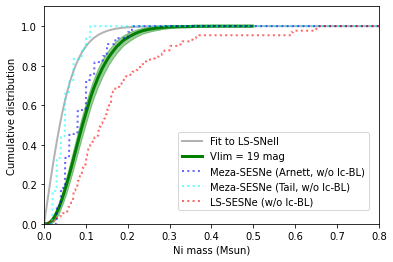

In [83]:
# Mock obs compared to data.

def plot_cum_ni_hist(array, bins, color, label, linestyle='solid'):
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(array, bins=bins)
    tot_num = np.sum(data_entries)
    cum = np.array([np.sum(data_entries[0:i])/tot_num for i in range(len(bins)-1)])
    plt.plot(binscenters, cum,linewidth = 2.0, color = color, alpha=0.6, label= label, linestyle=linestyle)
    
bins = np.linspace(0, 1.0, 1000)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

plt.plot(binscenters, F(binscenters), label="Fit to LS-SNeII", color="gray", alpha = 0.6, lw = 2) # anderson
#plt.errorbar(binscenters_ni, mean_ni_cum_bin[1,:], yerr=std_ni_cum_bin[1,:],linewidth = 3.0, color = "g", label="Vlim = 19 mag")
plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 3.0, color = "g", label="Vlim = 19 mag")
plt.fill_between(binscenters_ni, mean_ni_cum_bin[1,:] - std_ni_cum_bin[1,:], 
                 mean_ni_cum_bin[1,:] + std_ni_cum_bin[1,:], alpha=0.4, color="g")



plot_cum_ni_hist(ni_meza_arnett_excluding_IcBL, bins, "b", label= "Meza-SESNe (Arnett, w/o Ic-BL)", linestyle = "dotted")
plot_cum_ni_hist(ni_meza_tail_dropna_excluding_IcBL, bins, "cyan", label= "Meza-SESNe (Tail, w/o Ic-BL)", linestyle = "dotted")

plot_cum_ni_hist(ni_avg_SESNe_excluding_IcBL, bins, "r", label= "LS-SESNe (w/o Ic-BL)", linestyle = "dotted")


plt.xlim(0,0.8) # 0.55)
plt.ylim(0,1.1)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.4, 0.42), loc='upper left', borderaxespad=0, fontsize=10)
plt.savefig('Ni_dist_compare_19_to_data_excluding_IcBL.png', bbox_inches="tight") 

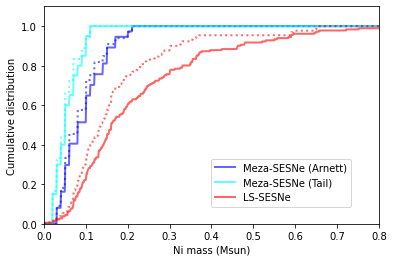

In [85]:
# Mock obs compared to data.

def plot_cum_ni_hist(array, bins, color, label, linestyle='solid'):
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(array, bins=bins)
    tot_num = np.sum(data_entries)
    cum = np.array([np.sum(data_entries[0:i])/tot_num for i in range(len(bins)-1)])
    plt.plot(binscenters, cum,linewidth = 2.0, color = color, alpha=0.6, label= label, linestyle=linestyle)
    
bins = np.linspace(0, 1.0, 1000)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

#plt.plot(binscenters, F(binscenters), label="Fit to LS-SNeII", color="gray", alpha = 0.6, lw = 2) # anderson
#plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 3.0, color = "g", label="Vlim = 19 mag")
#plt.fill_between(binscenters_ni, mean_ni_cum_bin[1,:] - std_ni_cum_bin[1,:], 
#                 mean_ni_cum_bin[1,:] + std_ni_cum_bin[1,:], alpha=0.4, color="g")


plot_cum_ni_hist(ni_meza_arnett, bins, "b", "Meza-SESNe (Arnett)")
plot_cum_ni_hist(ni_meza_arnett_excluding_IcBL, bins, "b", label= "", linestyle = "dotted")

plot_cum_ni_hist(ni_meza_tail_omit_none.astype(np.float64), bins, "cyan", "Meza-SESNe (Tail)")
plot_cum_ni_hist(ni_meza_tail_dropna_excluding_IcBL, bins, "cyan", label= "", linestyle = "dotted")

plot_cum_ni_hist(ni_avg_SESNe, bins, "r", "LS-SESNe")
plot_cum_ni_hist(ni_avg_SESNe_excluding_IcBL, bins, "r", label= "", linestyle = "dotted")

#plot_cum_ni_hist(ni_avg_SESNe[ni_avg_SESNe <=0.2], bins, "orange", "LS-SESNe ($^{56}$Ni mass <0.2Msun)")


plt.xlim(0,0.8) # 0.55)
plt.ylim(0,1.1)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.5, 0.3), loc='upper left', borderaxespad=0, fontsize=10)
plt.savefig('Ni_dist_compare_IcBL_excluding_IcBL.png', bbox_inches="tight") 

In [109]:
# K-S test

from scipy import stats

def KS_test(array1, cum_array2_x, cum_array2_y):
    '''
    Use scipy to conduct a K-S test.
    
    Input:
    array1 : array of data points. 
    cum_array_x: x_axis points for the cumulative distribution (e.g. [0.0, 0.1, 0.2, ...]).
    cum_array_y: y_axis points for the cumulative distribution.
    '''
    
    array2 = cumulative_to_original_data(cum_array2_x, cum_array2_y)
    
    return stats.kstest(array1, array2)
    

def cumulative_to_original_data(cum_array_x, cum_array_y):
    '''
    inverse transform sampling to create a list of random numbers that follow 
    a specified cumulative distribution.
    
    Input:
    cum_array_x: x_axis points for the cumulative distribution (e.g. [0.0, 0.1, 0.2, ...]).
    cum_array_y: y_axis points for the cumulative distribution.
    
    '''
    
    random.seed(0)
    
    y_random_points = random.random(size=500) # You can change the size if you want.
    x_random_points = convert_y_to_x(y_random_points, cum_array_x, cum_array_y)
    
    return x_random_points


def convert_y_to_x(y_random_points, cum_array_x, cum_array_y):
    '''
    A code that supplements the function above.
    '''
    
    x_random_points = []
    
    for num in y_random_points:
        diff_arr = abs(cum_array_y - num) 
        min_id = np.argmin(diff_arr) # Find index for the closest point to num.
        x_random_points.append(cum_array_x[min_id]) # Corresponding x ti min_id. This is a generarated random number.
      
    return x_random_points

   
print("LS-SNeII, LS-SESNe: ", stats.kstest(ni_avg_II, ni_avg_SESNe))
print("Meza (Arnett), LS-SESNe:", stats.ks_2samp(ni_meza_arnett, ni_avg_SESNe))

print("LS-SNeII, fit :", KS_test(ni_avg_II, binscenters, F(binscenters))) 
print()
print("LS-SNeII, Mock:", KS_test(ni_avg_II, binscenters_ni, mean_ni_cum_bin[1,:]))
print()
print("LS-SESNe, Mock:", KS_test(ni_avg_SESNe, binscenters_ni, mean_ni_cum_bin[1,:]))
print("LS-SESNe excluding Ic-BL, Mock:", KS_test(ni_avg_SESNe_excluding_IcBL, binscenters_ni, mean_ni_cum_bin[1,:]))
print()
print("Meza (Arnett), Mock:", KS_test(ni_meza_arnett, binscenters_ni, mean_ni_cum_bin[1,:]))
print("Meza (Arnett) excluding Ic-BL, Mock:", KS_test(ni_meza_arnett_excluding_IcBL, binscenters_ni, mean_ni_cum_bin[1,:]))
print()
print("Meza (Tail), Mock:", KS_test(ni_meza_tail_omit_none.astype(np.float64), binscenters_ni, mean_ni_cum_bin[1,:]))
print("Meza (Tail) excluding Ic-BL, Mock:", KS_test(ni_meza_tail_dropna_excluding_IcBL, binscenters_ni, mean_ni_cum_bin[1,:]))
print()

#print("Meza (Arnett), LS-SESNe [exclude Ic-BL]:", stats.ks_2samp(ni_meza_arnett_excluding_IcBL, ni_avg_SESNe_excluding_IcBL))

LS-SNeII, LS-SESNe:  KstestResult(statistic=0.6897465705649849, pvalue=3.421880027895907e-34)
Meza (Arnett), LS-SESNe: KstestResult(statistic=0.45338921809510047, pvalue=2.5622992672058587e-06)
LS-SNeII, fit : KstestResult(statistic=0.05982608695652174, pvalue=0.8681094890591331)

LS-SNeII, Mock: KstestResult(statistic=0.48095652173913045, pvalue=2.599138818864807e-20)

LS-SESNe, Mock: KstestResult(statistic=0.43179679144385025, pvalue=4.440892098500626e-16)
LS-SESNe excluding Ic-BL, Mock: KstestResult(statistic=0.31525190839694656, pvalue=1.1923189102702736e-09)

Meza (Arnett), Mock: KstestResult(statistic=0.1494054054054054, pvalue=0.3856450820315893)
Meza (Arnett) excluding Ic-BL, Mock: KstestResult(statistic=0.19854545454545455, pvalue=0.15091299350115706)

Meza (Tail), Mock: KstestResult(statistic=0.426, pvalue=0.0011476246001935753)
Meza (Tail) excluding Ic-BL, Mock: KstestResult(statistic=0.49266666666666664, pvalue=0.00020738880937976045)



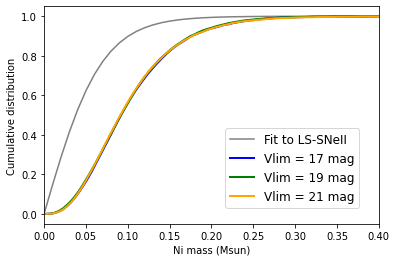

In [86]:
x_ni = np.arange(0,0.6,0.01)
y_ni = F(x_ni)
plt.plot(x_ni, y_ni, color="gray", label="Fit to LS-SNeII") # anderson

plt.plot(binscenters_ni, mean_ni_cum_bin[2,:],linewidth = 2.0, color = "b", label="Vlim = 17 mag")
plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 2.0, color = "g", label="Vlim = 19 mag")
plt.plot(binscenters_ni, mean_ni_cum_bin[0,:],linewidth = 2.0, color= "orange", label="Vlim = 21 mag")



plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.xlim(0,0.4)
plt.legend(bbox_to_anchor=(0.47, 0.55), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Ni_cum_dist_different_Vlim.png', bbox_inches="tight")

17: 0.7965197925197939
19: 0.8694365274365287
21: 0.8977163527163539


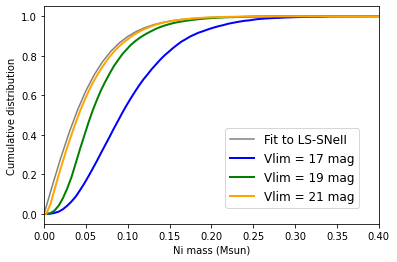

In [108]:
# Compare the volume-limited samples for the different Vlims.

x_ni = np.arange(0,0.6,0.01)
y_ni = F(x_ni)
plt.plot(x_ni, y_ni, color="gray", label="Fit to LS-SNeII") # anderson

plt.plot(binscenters_ni, mean_ni_cum_Dmax_close_bin[2,:],linewidth = 2.0, color = "b", label="Vlim = 17 mag")
plt.plot(binscenters_ni, mean_ni_cum_Dmax_close_bin[1,:],linewidth = 2.0, color = "g", label="Vlim = 19 mag")
plt.plot(binscenters_ni, mean_ni_cum_Dmax_close_bin[0,:],linewidth = 2.0, color= "orange", label="Vlim = 21 mag")


plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.xlim(0,0.4)
plt.legend(bbox_to_anchor=(0.47, 0.55), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Ni_cum_dist_in_volume_limited_samples_for_different_Vlim.png', bbox_inches="tight")

print("17:", np.mean(mean_ni_cum_Dmax_close_bin[2,:]))
print("19:", np.mean(mean_ni_cum_Dmax_close_bin[1,:]))
print("21:", np.mean(mean_ni_cum_Dmax_close_bin[0,:]))

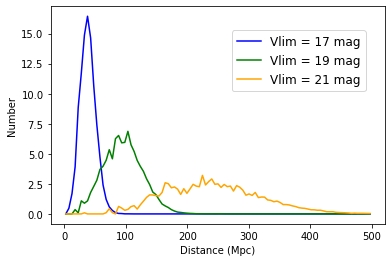

In [88]:
# Different limiting magnitudes
# Calculate mean and std of Distance.

##mean_distance_bin = np.zeros((3,num_bins_dist-1))
#std_distance_bin = np.zeros((3,num_bins_dist-1))
  
binscenters = np.array([0.5*(bins_dist[i] + bins_dist[i+1]) for i in range(len(bins_dist)-1)])

plt.plot(binscenters, mean_distance_bin[2,:], color = "b", label="Vlim = 17 mag") # linewidth = 8.0
plt.plot(binscenters, mean_distance_bin[1,:], color = "g", label="Vlim = 19 mag") # linewidth = 6.0
plt.plot(binscenters, mean_distance_bin[0,:], color = "orange", label="Vlim = 21 mag") # linewidth = 2.0

#plt.errorbar(binscenters, mean_distance_bin[2,:], yerr= std_distance_bin[2,:], color = "b") # linewidth = 8.0
#plt.errorbar(binscenters, mean_distance_bin[1,:], yerr= std_distance_bin[1,:], color = "y") # linewidth = 6.0
#plt.errorbar(binscenters, mean_distance_bin[0,:], yerr= std_distance_bin[0,:], color = "r") # linewidth = 2.0


plt.xlabel("Distance (Mpc)")
plt.ylabel("Number")
#plt.xlim(0,0.5)
plt.legend(bbox_to_anchor=(0.47, 1.0), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Distance_distribution_different_Vlim.png', bbox_inches="tight")#

------------------------
Start mock observation for Vlim =  21.0
Dmax =  795.2990000155829
Random seed =  0
Finished mock observation for Vlim =  21.0
------------------------
Start mock observation for Vlim =  19.0
Dmax =  316.61423464023056
Random seed =  1
Finished mock observation for Vlim =  19.0
------------------------
Start mock observation for Vlim =  17.0
Dmax =  126.04639710958368
Random seed =  2
Finished mock observation for Vlim =  17.0


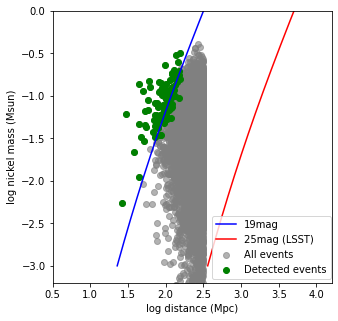

In [95]:
def plot_const_Vlim_line(Vlim, label, color):
    logNi_list = np.arange(-3.0,0.5,0.0001)
    logL_tmp= np.log10(Lpeak_for_MNi_direct(10**logNi_list, a_coef, b_coef).astype(np.float64)) 
    logd_lim_list = np.log10(D_lim(logL_tmp,Vlim)) 
    plt.plot(logd_lim_list,logNi_list,label=label, color = color)

Vlim_list = [21.0, 19.0, 17.0]

ni_all_events = [[] for i in range(len(Vlim_list))] 
Dist_all_events = [[] for i in range(len(Vlim_list))]

num_detect = 100 # Stop one iteration once the detected number reaches this number                                                                                                                                                                                                           
#print(num_detect)
assert num_detect == 100

ni_obs_different_Vlim_one_iteration = np.zeros((len(Vlim_list), 1, num_detect))
lgL_obs_different_Vlim_one_iteration = np.zeros((len(Vlim_list), 1, num_detect))
Dist_obs_different_Vlim_one_iteration = np.zeros((len(Vlim_list), 1, num_detect))

for l in range(len(Vlim_list)):
    
    Vlim = Vlim_list[l]
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef, b_coef)), Vlim)
    
    # Note that N_iter=1
    ni_all_events[l], Dist_all_events[l] = Mockobs_for_a_given_Vlim(
        Vlim, t_cadence, 1, N_events_maximum, num_detect, Dmax, l, False , 
        ni_obs_different_Vlim_one_iteration, lgL_obs_different_Vlim_one_iteration, 
        Dist_obs_different_Vlim_one_iteration
        )
    
fig = plt.figure(figsize = (5, 5))

assert len(Dist_all_events[1]) > len(Dist_obs_different_Vlim_one_iteration[1][0])

plt.scatter(np.log10(Dist_all_events[1]), np.log10(ni_all_events[1]), alpha =0.6, label="All events", color='gray')
plt.scatter(np.log10(Dist_obs_different_Vlim_one_iteration[1][0]), np.log10(ni_obs_different_Vlim_one_iteration[1][0]),  alpha =1., label="Detected events", color='green')

plot_const_Vlim_line(19, '19mag', 'b')
plot_const_Vlim_line(25, '25mag (LSST)', 'r')

plt.xlabel("log distance (Mpc)") #, size = 14)
plt.ylabel("log nickel mass (Msun)") # , size = 14)
plt.xlim(0.5,4.2)
plt.ylim(-3.2,0.0)
plt.legend(bbox_to_anchor=(0.5, 0.32), loc='upper left', borderaxespad=2, fontsize=10)
plt.savefig('Ni_vs_distance_wt_mock_no_obs_data.png', bbox_inches="tight") 


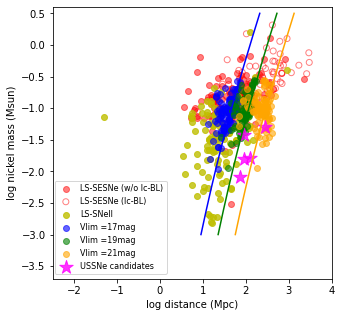

In [94]:

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 5))

plot_const_Vlim_line(17, '', 'b')
plot_const_Vlim_line(19, '', 'g')
plot_const_Vlim_line(21, '', 'orange')

plt.scatter(np.log10(distance_SESNe_excluding_IcBL),np.log10(ni_avg_SESNe_excluding_IcBL), color="r", alpha=0.5, label = "LS-SESNe (w/o Ic-BL)") #: Meza & Anderson (2020)")
plt.scatter(np.log10(distance_SESNe_IcBL),np.log10(ni_avg_SESNe_IcBL), color="r", alpha=0.5, facecolor='none', label = "LS-SESNe (Ic-BL)") #: Meza & Anderson (2020)")
#plt.scatter(np.log10(distance_SESNe),np.log10(ni_avg_SESNe), color="r", alpha=1.0, label = "LS-SESNe") #: Meza & Anderson (2020)")
plt.scatter(np.log10(distance_II),np.log10(ni_avg_II), alpha=0.8, color="y", label = "LS-SNeII") # : Hamuy (2003) & Pejcha & Prieto (2015)")

plt.scatter(np.log10(Dist_obs_different_Vlim_one_iteration[2][0][:]), np.log10(ni_obs_different_Vlim_one_iteration[2][0][:]), alpha =0.6, label="Vlim =17mag", color='b')
plt.scatter(np.log10(Dist_obs_different_Vlim_one_iteration[1][0][:]), np.log10(ni_obs_different_Vlim_one_iteration[1][0][:]), alpha =0.6, label="Vlim =19mag", color='g')
plt.scatter(np.log10(Dist_obs_different_Vlim_one_iteration[0][0][:]), np.log10(ni_obs_different_Vlim_one_iteration[1][0][:]), alpha =0.6, label="Vlim =21mag", color='orange')

plt.scatter(np.log10(distance_USSNe),np.log10(ni_avg_USSNe), alpha=0.8, color="magenta", marker='*', s=200, label = "USSNe candidates") 
     
plt.xlabel("log distance (Mpc)") #, size = 14)
plt.ylabel("log nickel mass (Msun)") # , size = 14)
plt.xlim(-2.5,4.0)
plt.ylim(-3.7,0.6)
plt.legend(bbox_to_anchor=(-0.05, 0.42), loc='upper left', borderaxespad=2, fontsize=8)
plt.savefig('Ni_vs_distance_wt_mock.png', bbox_inches="tight") 

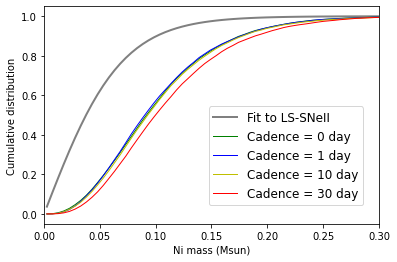

In [125]:
# 異なるcadence

binscenters_cadence = np.array([0.5*(bins_cadence[i] + bins_cadence[i+1]) for i in range(len(bins_cadence)-1)])

plt.plot(binscenters_ni, F(binscenters_ni), color="gray", label="Fit to LS-SNeII", lw = 2.0) # anderson
plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 1, color = "g", label="Cadence = 0 day")

#cadence_list = [10.0, 20.0, 30.0]
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[0,:],linewidth = 1, color = "b", label="Cadence = 1 day")
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[1,:],linewidth = 1, color = "y", label="Cadence = 10 day")
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[2,:],linewidth = 1, color= "r", label="Cadence = 30 day")

plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.42, 0.65), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Ni_cum_dist_different_cadence.png', bbox_inches="tight")

#print("1 day: ", np.mean(mean_ni_cadence_cum_bin[0,:]))
#print("10 day: ", np.mean(mean_ni_cadence_cum_bin[1,:]))
#print("30 day: ", np.mean(mean_ni_cadence_cum_bin[2,:]))

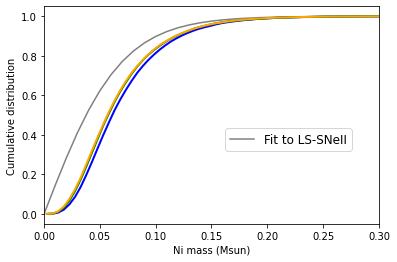

In [61]:
# Compare the volume-limited samples for the different Vlims.

x_ni = np.arange(0,0.6,0.01)
y_ni = F(x_ni)
plt.plot(x_ni, y_ni, color="gray", label="Fit to LS-SNeII") # anderson

plt.plot(binscenters_ni, mean_ni_different_cadence_cum_Dmax_close_bin[2,:],linewidth = 2.0, color = "b", label="")
plt.plot(binscenters_ni, mean_ni_different_cadence_cum_Dmax_close_bin[1,:],linewidth = 2.0, color = "g", label="")
plt.plot(binscenters_ni, mean_ni_different_cadence_cum_Dmax_close_bin[0,:],linewidth = 2.0, color= "orange", label="")


plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.47, 0.55), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Ni_cum_dist_in_volume_limited_samples_for_different_cadence.png', bbox_inches="tight")

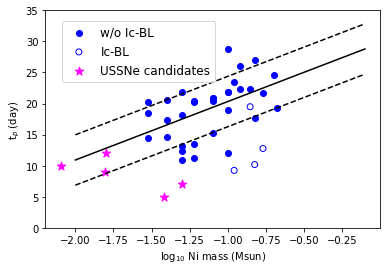

In [112]:
if which_Ni_mass=="arnett":
    x = np.log10(ni_meza_arnett_excluding_IcBL)
    y = tp_meza_excluding_IcBL 
elif whichi_Ni_mass=="tail":
    x = np.log10(ni_meza_tail_dropna_excluding_IcBL)
    y = tp_meza_tail_dropna_excluding_IcBL 
else:
    print("Error: which_Ni_mass should inapproproate.")
    

x_temp = np.arange(-2.,-0.1,0.001)
y_temp = a_coef*x_temp + b_coef # lr.predict(x_temp) # coe[0]*x + coe[1]

# attach error.
y_up = y_temp + tp_err
y_down = y_temp - tp_err

tp_err = tp_err # So that the meaning is clearer. We will use this later.

if which_Ni_mass=="arnett":
    plt.scatter(np.log10(ni_meza_arnett_excluding_IcBL), tp_meza_excluding_IcBL, color="b", label = "w/o Ic-BL")
    plt.scatter(np.log10(ni_meza_arnett_IcBL), tp_meza_IcBL, color="b", facecolors='none', label = "Ic-BL")

elif whichi_Ni_mass=="tail":
    plt.scatter(np.log10(ni_meza_tail_dropna_excluding_IcBL), tp_meza_tail_dropna_excluding_IcBL, color="r", label = "w/o Ic-BL")
    plt.scatter(np.log10(ni_meza_tail_dropna_IcBL), tp_meza_tail_dropna_IcBL, color="r", facecolors='none', label = "Ic-BL")

else: # kk
    print("Error.")
 #   plt.scatter(np.log10(ni_meza_kk_excluding_IcBL), tp_meza_excluding_IcBL, color="g", label = "Not Ic-BL")
 #   plt.scatter(np.log10(ni_meza_kk_IcBL), tp_meza_IcBL, color="g", facecolors='none', label = "Ic-BL")


# if you want to add USSNe plot.
#Data of USSNe:
ni_USSNe = [0.016, 0.0500, 0.008, 0.038, 0.0157]
tp_USSNe = [12, 7, 10, 5, 9]

plt.scatter(np.log10(ni_avg_USSNe), tp_USSNe, s=80, color='magenta', marker = '*', alpha=1.0, label='USSNe candidates')

plt.plot(x_temp, y_temp, color="black")
plt.plot(x_temp, y_up, color="black", linestyle='dashed')
plt.plot(x_temp, y_down, color="black", linestyle='dashed')


plt.xlabel("log$_{10}$ Ni mass (Msun)")
plt.ylabel("t$_p$ (day)")

plt.ylim(0,35)

plt.legend(bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0, fontsize=12)
plt.savefig('Ni_vs_tau.png', bbox_inches="tight") 


# The case when we use Tail Ni mass for the fit

## Fit to tp and Lp 

2.6468651343404885 23.58823751206389 3.803297762081775 5.186170928832099 3.6666882702874197


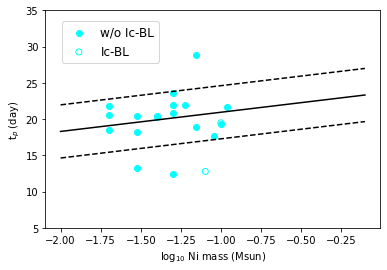

In [113]:
which_Ni_mass = "tail" 
# Which methods of deriving Ni mass do you use when fitting tp vs Ni ?
# You can specify either "arnett" or "tail".


a_coef_tail, b_coef_tail, a_err_tail, b_err_tail, tp_err_tail = fit_tp_vs_Ni(which_Ni_mass)
plot_fit_tp_vs_Ni(which_Ni_mass, 'Ni_vs_tp_from_meza_tail.png', a_coef_tail, b_coef_tail, tp_err_tail, plot_USSNe_flag=False)  

print(a_coef_tail, b_coef_tail, a_err_tail, b_err_tail, tp_err_tail)

(array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
        0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
        0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
        0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
        0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
        0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
        0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
        0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
        0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
        0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
        0.127, 0.128, 0.129, 0.13 , 0.131, 0.132, 0.133, 0.134, 0.135,
      

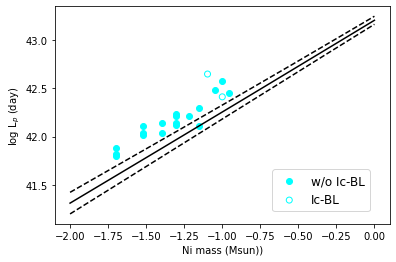

In [114]:
plot_Lp_vs_Ni('tail', 'Consistency_check_for_Lp_tail.png', a_coef_tail, b_coef_tail, tp_err_tail, plot_USSNe_flag=False)

## Mock observation 

In [115]:

# mock observation for Different limiting magnitude Vlim.

Vlim_list = [21.0, 19.0, 17.0] # Different limiting magnitude you want to try.
Ni_lim = 1.0 # Limiting Ni mass (Msun). This determines the outer distance boundary.

# Arraies for the properties of detect samples.
ni_obs_diff_Vlim_tail = np.zeros((3, N_iter,num_detect))
lgL_obs_diff_Vlim_tail = np.zeros((3, N_iter,num_detect))
Dist_obs_diff_Vlim_tail = np.zeros((3, N_iter,num_detect))

# Make sure the size of list is correct.
assert ni_obs_diff_Vlim_tail.shape == (len(Vlim_list), N_iter, num_detect)
assert lgL_obs_diff_Vlim_tail.shape == (len(Vlim_list), N_iter, num_detect)
assert Dist_obs_diff_Vlim_tail.shape == (len(Vlim_list), N_iter, num_detect)

print("which_Ni_mass = ", which_Ni_mass)

# I could write a code better....
a_coef = a_coef_tail 
b_coef = b_coef_tail

for l in range(len(Vlim_list)):
    Vlim = Vlim_list[l]
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef_tail, b_coef_tail)), Vlim)
    
    start = time.time()  
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False , ni_obs_diff_Vlim_tail, lgL_obs_diff_Vlim_tail, Dist_obs_diff_Vlim_tail)
    elapsed_time = time.time() - start
    
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("------------------------")
print("Finished all calculations !") 

which_Ni_mass =  tail
------------------------
Start mock observation for Vlim =  21.0
Dmax =  876.4934663387448
Random seed =  0
Finished mock observation for Vlim =  21.0
elapsed_time:281.44785833358765[sec]
------------------------
Start mock observation for Vlim =  19.0
Dmax =  348.9383338927458
Random seed =  1
Finished mock observation for Vlim =  19.0
elapsed_time:269.7760651111603[sec]
------------------------
Start mock observation for Vlim =  17.0
Dmax =  138.91485280369187
Random seed =  2
Finished mock observation for Vlim =  17.0
elapsed_time:279.5061581134796[sec]
------------------------
Finished all calculations !


In [116]:
# Take the mean and std of N_iter iterations.

# Ni mass
mean_ni_tail_bin, std_ni_tail_bin, mean_ni_cum_tail_bin, std_ni_cum_tail_bin = calculate_mean_and_std(ni_obs_diff_Vlim_tail, bins_ni)

# log Lpeak
mean_lgL_tail_bin, std_lgL_tail_bin, _, _ = calculate_mean_and_std(lgL_obs_diff_Vlim_tail, bins_lgL)

# Distance
mean_distance_tail_bin, std_distance_tail_bin, _, _ = calculate_mean_and_std(Dist_obs_diff_Vlim_tail, bins_dist)

In [117]:
# サンプル数が37の場合
# Vlim=19におけるmock観測 

N_iter = 1000 # 10000                                                                                                                                                                                                                            
num_detect = 37 # 189 #150                                                                                                                                                                                                                   

ni_obs_Vlim_19_sample_37_tail = np.zeros((1, N_iter,num_detect))
lgL_obs_Vlim_19_sample_37_tail = np.zeros((1, N_iter,num_detect))
Dist_obs_Vlim_19_sample_37_tail = np.zeros((1, N_iter,num_detect))
                                                                                                                                                            
Vlim_list = [19.0]

start = time.time()

for l in range(1):
    Vlim = Vlim_list[l]
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef_tail, b_coef_tail)), Vlim)
    assert num_detect == 37
    Mockobs_for_a_given_Vlim(Vlim, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, False, ni_obs_Vlim_19_sample_37_tail, lgL_obs_Vlim_19_sample_37_tail, Dist_obs_Vlim_19_sample_37_tail)
    
    
# Vlim=infにおけるmock観測                             
Vlim_inf_flag= True

ni_obs_Vlim_inf_sample_37_tail = np.zeros((1, N_iter,num_detect))
lgL_obs_Vlim_inf_sample_37_tail = np.zeros((1, N_iter,num_detect))
Dist_obs_Vlim_inf_sample_37_tail = np.zeros((1, N_iter,num_detect))                           

for l in range(1):
    assert Vlim_inf_flag == True
    Dmax = D_lim(np.log10(Lpeak_for_MNi_direct(Ni_lim, a_coef_tail, b_coef_tail)), 19.) # Use 19.
    Mockobs_for_a_given_Vlim(19, t_cadence, N_iter, N_events_maximum, num_detect, Dmax, l, True, ni_obs_Vlim_inf_sample_37_tail, lgL_obs_Vlim_inf_sample_37_tail, Dist_obs_Vlim_inf_sample_37_tail)
    
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

------------------------
Start mock observation for Vlim =  19.0
Dmax =  348.9383338927458
Random seed =  0
Finished mock observation for Vlim =  19.0
------------------------
Start mock observation for Vlim =  19
Dmax =  348.9383338927458
Random seed =  0
Finished mock observation for Vlim =  19
elapsed_time:205.2155420780182[sec]


In [118]:
# Take the mean and std of N_iter iterations.

# log Lpeak
mean_lgL_37_tail_bin, std_lgL_37_tail_bin, _, _ = calculate_mean_and_std(lgL_obs_Vlim_19_sample_37_tail, bins_lgL)
mean_lgL_37_inf_tail_bin, std_lgL_37_inf_tail_bin, _, _ = calculate_mean_and_std(lgL_obs_Vlim_inf_sample_37_tail, bins_lgL)

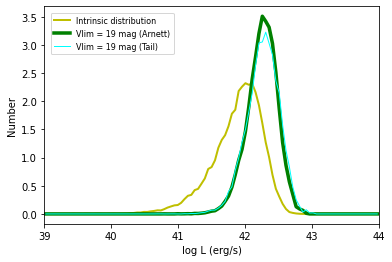

In [119]:
# Compare luminosity function to data.

# Better to make errorbars contour?

plt.xlim(39,44)

plt.xlabel("log L (erg/s)")
plt.ylabel("Number")


#plt.hist(lgL_meza, bins=10, alpha = 1.0, density =False,color="b", label = "Meza-SESNe (total)") 
#plt.hist(lgL_meza_excluding_IcBL, bins=10, alpha = 1.0, density =False,color="orange", label = "Meza-SESNe (excluding Ic-BL)", histtype="step") 
#plt.hist(lgL_meza_IcBL, bins=10, alpha = 1.0, density =False,color="orange", 
#        label = "Meza-SESNe (only Ic-BL)", histtype="step", linestyle='dotted') 



plt.plot(binscenters_lgL, mean_lgL_37_inf_bin[0,:],linewidth = 2.0, color = "y", label="Intrinsic distribution")

plt.plot(binscenters_lgL, mean_lgL_37_bin[0,:], linewidth = 3.5, color = "g", label="Vlim = 19 mag (Arnett)")
#plt.errorbar(binscenters_lgL, mean_lgL_37_bin[0,:], yerr=std_lgL_37_bin[0,:],linewidth = 2.0, color = "g", label="Vlim = 19 mag (Arnett)")

plt.plot(binscenters_lgL, mean_lgL_37_tail_bin[0,:],linewidth = 1.0, color = "cyan", label="Vlim = 19 mag (Tail)")
#plt.errorbar(binscenters_lgL, mean_lgL_37_tail_bin[0,:], yerr=std_lgL_37_tail_bin[0,:],linewidth = 1.0, color = "r", label="Vlim = 19 mag (Tail)")



plt.legend(bbox_to_anchor=(0.02, 0.97), loc='upper left', borderaxespad=0, fontsize=8)
plt.savefig('L_dist_compare_intrinsic_to_observed_add_tail.png', bbox_inches="tight") 

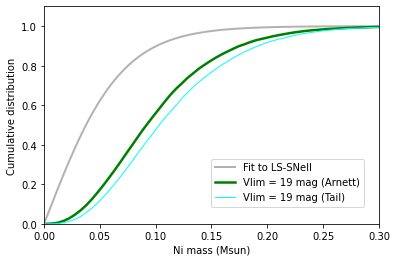

In [120]:
    
bins = np.linspace(0, 1.0, 1000)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

plt.plot(binscenters, F(binscenters), label="Fit to LS-SNeII", color="gray", alpha = 0.6, lw = 2) # anderson

plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 2.5, color = "g", label="Vlim = 19 mag (Arnett)")
plt.plot(binscenters_ni, mean_ni_cum_tail_bin[1,:],linewidth = 1., color = "cyan", label="Vlim = 19 mag (Tail)")
#plt.errorbar(binscenters_ni, mean_ni_cum_bin[1,:], yerr=std_ni_cum_bin[1,:],linewidth = 3.0, color = "g", label="Vlim = 19 mag (Arnett)")
#plt.errorbar(binscenters_ni, mean_ni_cum_tail_bin[1,:], yerr=std_ni_cum_tail_bin[1,:],linewidth = 3.0, color = "y", label="Vlim = 19 mag (Tail)")

plt.xlim(0,0.3) # 0.55)
plt.ylim(0,1.1)
plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.legend(bbox_to_anchor=(0.5, 0.3), loc='upper left', borderaxespad=0, fontsize=10)
plt.savefig('Ni_dist_compare_19_to_data_add_tail.png', bbox_inches="tight") 

# Previous results

In [38]:
len(ni_avg_SESNe_excludingIcBL[ni_avg_SESNe_excludingIcBL<=0.2])/len(ni_avg_SESNe)

0.5210526315789473

In [136]:
(len(ni_SESNe_all)-len(ni_SESNe_all_exclude_Ni_mass_more_than_03))/len(ni_SESNe_all)

0.24338624338624337

10 day:  0.7823795320552464
20 day:  0.7729673242630385
30 day:  0.7724788146773861


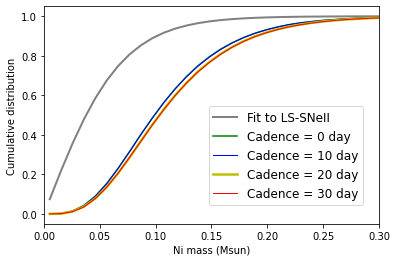

In [120]:
# 異なるcadence

# Calculate mean and std. (Ni mass)

num_bins_cadence = 50
bins_cadence = np.linspace(0, 0.5, num_bins_cadence)

   
binscenters_cadence = np.array([0.5*(bins_cadence_[i] + bins_cadence_[i+1]) for i in range(len(bins_cadence_)-1)])

plt.plot(binscenters_ni, F(binscenters_ni), color="gray", label="Fit to LS-SNeII", lw = 2.0) # anderson

plt.plot(binscenters_ni, mean_ni_cum_bin[1,:],linewidth = 1.5, color = "g", label="Cadence = 0 day")

#cadence_list = [10.0, 20.0, 30.0]
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[0,:],linewidth = 1, color = "b", label="Cadence = 10 day")
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[1,:],linewidth = 2.5, color = "y", label="Cadence = 20 day")
plt.plot(binscenters_cadence, mean_ni_cadence_cum_bin[2,:],linewidth = 1, color= "r", label="Cadence = 30 day")

plt.xlabel("Ni mass (Msun)")
plt.ylabel("Cumulative distribution")
plt.xlim(0,0.3)
plt.legend(bbox_to_anchor=(0.42, 0.65), loc='upper left', borderaxespad=2, fontsize=12)

plt.savefig('Ni_cum_dist_different_cadence.png', bbox_inches="tight")

print("10 day: ", np.mean(mean_ni_cum_bin_cadence[0,:]))
print("20 day: ", np.mean(mean_ni_cum_bin_cadence[1,:]))
print("30 day: ", np.mean(mean_ni_cum_bin_cadence[2,:]))

In [ ]:
### Investigate the dependence on cadence.

In [217]:
Lpeak_for_M_Ni_SNII(0.01)
#SNIIのMock観測

Dmax = 500 # Mpc,  roughly corresponds to lgL=44.5 limit.
ymax = 1 # ここを1としていいはず。つまり1/10**9する。

N_dist = 10000 # これは固定。

SNII_ni_obs_19 = []
SNII_lgL_obs_19 = []
SNII_Dist_obs_19 = []


for i in range(len(ni_rand)):
    lgL_tmp = np.log10(Lpeak_for_M_Ni_SNII(ni_rand[i])) 
    D_lim_tmp = D_lim(lgL_tmp,19.0)
    
    #観測開始。色々なDで発生させる。
    x_rad =  np.random.rand(N_dist)
    y_rad = np.random.rand(N_dist)

    x_i = Dmax*x_rad
    y_i = ymax*y_rad

    for j in range(N_dist):
        border = x_i[j]**3/pow(10,9)
        if (y_i[j] <= border and x_i[j] <= D_lim_tmp): 
            #event.append(1) # try 観測
            SNII_ni_obs_19.append(ni_rand[i])
            SNII_lgL_obs_19.append(lgL_tmp)
            SNII_Dist_obs_19.append(x_i[j])
            
print("done: ", len(SNII_lgL_obs_19)/10**8)

done:  4.117e-05


In [14]:
data_SESNe_lyman_prentice = data_SESNe.dropna(subset=['t_peak_avg'])
data_SESNe_lyman_prentice_excluding_IcBL = data_SESNe_lyman_prentice[data_SESNe_lyman_prentice['Type']!='Ic-BL']
data_SESNe_lyman_prentice_IcBL = data_SESNe_lyman_prentice[data_SESNe_lyman_prentice['Type']=='Ic-BL']


#[data_SESNe['Reference']=='Lyman+16'] # .dropna(subset=['SN']) # .dropna(subset=['Distance'])
ni_lyman_prentice = data_SESNe_lyman_prentice['Ni56 mass']
tp_lyman_prentice = data_SESNe_lyman_prentice['t_peak_avg']

ni_lyman_prentice_excluding_IcBL = data_SESNe_lyman_prentice_excluding_IcBL['Ni56 mass']
tp_lyman_prentice_excluding_IcBL = data_SESNe_lyman_prentice_excluding_IcBL['t_peak_avg']

ni_lyman_prentice_IcBL = data_SESNe_lyman_prentice_IcBL['Ni56 mass']
tp_lyman_prentice_IcBL = data_SESNe_lyman_prentice_IcBL['t_peak_avg']



print(len(ni_lyman_prentice))
print(len(ni_lyman_prentice_excluding_IcBL))

KeyError: ['t_peak_avg']

In [20]:
### Data of USSNe ###
ni_USSNe = [0.016, 0.0500, 0.008, 0.038, 0.0157]
tp_USSNe = [12, 7, 10, 5, 9]

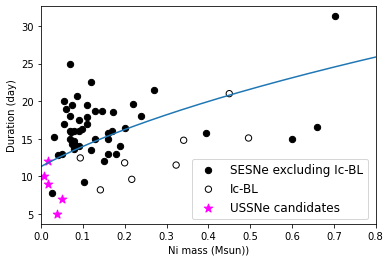

In [383]:
# plot tau for Ni using Lyman & Prentice (+USSNe).

plt.xlabel("Ni mass (Msun))")
plt.ylabel("Duration (day)")

ni_X_list = np.arange(0.0,1.0,0.001)

plt.xlim(0,0.8)
##plt.ylim(10.0,20.0)

tau_for_M_Ni(ni_X_list)
plt.plot(ni_X_list, tau_for_M_Ni(ni_X_list))
#plt.scatter(ni_lyman, tp_lyman, s=200)


plt.scatter(ni_lyman_prentice_excluding_IcBL, tp_lyman_prentice_excluding_IcBL, s=40, color='black', alpha=1.0, label= 'SESNe excluding Ic-BL')
plt.scatter(ni_lyman_prentice_IcBL, tp_lyman_prentice_IcBL, s=40, color='black', facecolor="None", alpha=1.0, label='Ic-BL')
plt.scatter(ni_USSNe, tp_USSNe, s=80, color='magenta', marker = '*', alpha=1.0, label='USSNe candidates')


plt.legend(bbox_to_anchor=(0.45, 0.3), loc='upper left', borderaxespad=0, fontsize=12)
plt.savefig('Ni_vs_tau.png', bbox_inches="tight") 

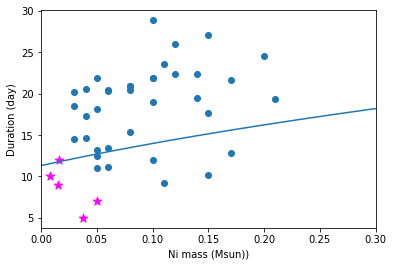

In [27]:
# plot tau for Ni using Lyman & Prentice (+USSNe).

plt.xlabel("Ni mass (Msun))")
plt.ylabel("Duration (day)")

ni_X_list = np.arange(0.0,1.0,0.001)

plt.xlim(0,0.3)
##plt.ylim(10.0,20.0)

tau_for_M_Ni(ni_X_list)
plt.plot(ni_X_list, tau_for_M_Ni(ni_X_list))
#plt.scatter(ni_lyman, tp_lyman, s=200)


#plt.scatter(ni_lyman_prentice_excluding_IcBL, tp_lyman_prentice_excluding_IcBL, s=40, color='black', alpha=1.0, label= 'SESNe excluding Ic-BL')
#plt.scatter(ni_lyman_prentice_IcBL, tp_lyman_prentice_IcBL, s=40, color='black', facecolor="None", alpha=1.0, label='Ic-BL')
plt.scatter(ni_USSNe, tp_USSNe, s=80, color='magenta', marker = '*', alpha=1.0, label='USSNe candidates')
plt.scatter(ni_meza, tp_meza)

#plt.legend(bbox_to_anchor=(0.45, 0.3), loc='upper left', borderaxespad=0, fontsize=12)
#plt.savefig('Ni_vs_tau.png', bbox_inches="tight") 

/Users/oouchiryouma/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


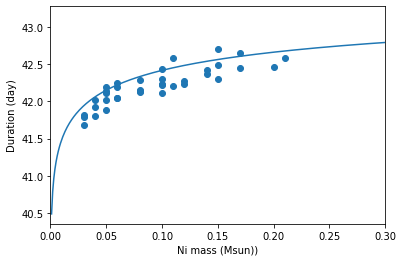

In [31]:
# plot tau for Ni using Lyman & Prentice (+USSNe).

plt.xlabel("Ni mass (Msun))")
plt.ylabel("Duration (day)")

ni_X_list = np.arange(0.0,1.0,0.001)

plt.xlim(0,0.3)
##plt.ylim(10.0,20.0)

tau_for_M_Ni(ni_X_list)
plt.plot(ni_X_list, np.log10(Lpeak_for_M_Ni(ni_X_list)*ni_X_list) + 43.0)


#plt.scatter(ni_lyman_prentice_excluding_IcBL, tp_lyman_prentice_excluding_IcBL, s=40, color='black', alpha=1.0, label= 'SESNe excluding Ic-BL')
#plt.scatter(ni_lyman_prentice_IcBL, tp_lyman_prentice_IcBL, s=40, color='black', facecolor="None", alpha=1.0, label='Ic-BL')
#plt.scatter(ni_USSNe, tp_SSNe, s=80, color='magenta', marker = '*', alpha=1.0, label='USSNe candidates')
plt.scatter(ni_meza, lgL_meza)

#plt.legend(bbox_to_anchor=(0.45, 0.3), loc='upper left', borderaxespad=0, fontsize=12)
#plt.savefig('Ni_vs_tau.png', bbox_inches="tight") 

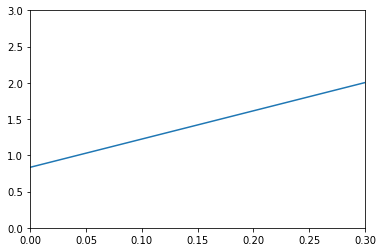

In [136]:
# plot tau for Ni.

ni_X_list = np.arange(0.0,1.0,0.001)

plt.xlim(0,0.3)
plt.ylim(0.0,3.0)

E_k_for_M_Ni(ni_X_list)
plt.plot(ni_X_list, E_k_for_M_Ni(ni_X_list))


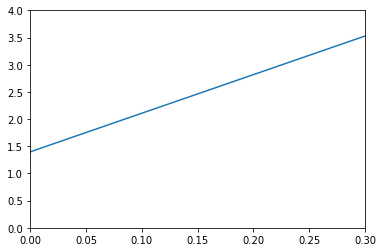

In [131]:
# plot Mej for Ni.

ni_X_list = np.arange(0.0,1.0,0.001)

plt.xlim(0,0.3)
plt.ylim(0.0,4.0)

M_ej_for_M_Ni(ni_X_list)
plt.plot(ni_X_list, M_ej_for_M_Ni(ni_X_list))

In [29]:
########################

# Below are the information for Joe-san's comments.

########################